<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Part 2: <strong>Neural Network Modeling</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>of time series</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Análise de Séries Temporais e Previsão 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
import logging

In [2]:
# Desativa mensagem constante dos dispositivos disponíveis para treino de modelos
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, rmse, r2_score
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import seaborn as sns

In [8]:
import optuna

In [9]:
# Inicializa ficheiro de armazenamento de trials do Optuna
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

# Inicialização das Séries

In [10]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [11]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [12]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [13]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [14]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [15]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [16]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [17]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 784
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 843
5 UK_Daily_Policy_Data 8886


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

Escolha da série temporal a modelar:

In [19]:
series_chosen = 1
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

Escolha das métricas a avaliar, incluindo seleção de uma principal para otimização de hiperparâmetros.

In [20]:
metrics = [smape, r2_score]
main_metric = metrics[0]
assert main_metric in metrics

In [21]:
splitting = 0.9
visualizing = 0.7

In [22]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

Scaling das séries temporais para treino das redes neuronais.

In [23]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [24]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

# Modelação de Time Series com Redes Neuronais

O pacote *darts* possibilita o uso de várias arquiteturas de redes neuronais para modelação de séries temporais. Para a construção e treino das redes, utiliza como backend o pacote pytorch-lightning, um framework para pytorch.

Utilizamos uma GPU para treinar os nossos modelos localmente. 

In [25]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [27]:
# Criacao de um callback de logging dos losses de treino e validacao
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [28]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.00001 (`min_delta`) 
# over a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [29]:
from darts.models import RNNModel, BlockRNNModel

### Treino de LSTM

Construção da primeira rede neuronal com hiperparâmetros default.

In [30]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),     # Estes hiperparametros sao um fator da dimensao da serie a ser modelada
    input_chunk_length=int(len(val)/4),  # para garantir inputs de dimensao adequada
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [31]:
# Treino do modelo com validacao
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                 | 0/? [00:00<?, ?it/s]

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=36, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=18, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000025F04959990>, <__main__.LossRecorder object at 0x0000025F08695900>]})

O modelo apresenta uma aprendizagem adequada ao longo das épocas de treino.

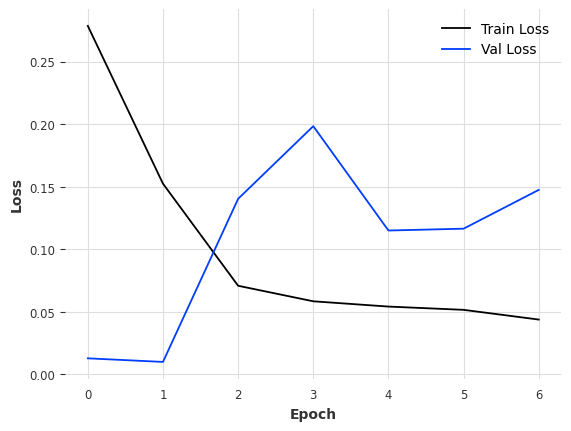

In [32]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=36, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=18, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000261AFFE7880>, <__main__.LossRecorder object at 0x00000261AFFE7B20>]})

In [34]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                      | 0/? [00:00<?, ?it/s]

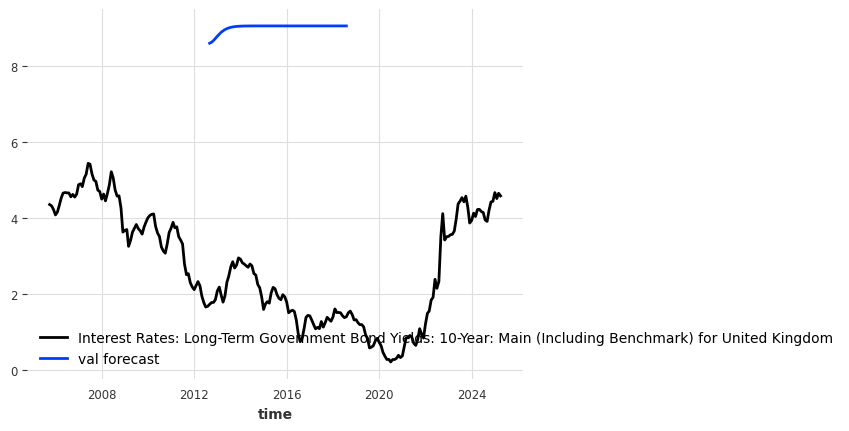

In [35]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

O modelo 

### Treino de NBEATS

Como experiência, treinamos também uma arquitetura de redes neuronais mais

In [36]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [37]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    batch_size=64,
    n_epochs=100, 
    random_state=7, 
    optimizer_kwargs={"lr": 1e-4},
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                 | 0/? [00:00<?, ?it/s]

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                        | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                      | 0/? [00:00<?, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=64, n_epochs=100, random_state=7, optimizer_kwargs={'lr': 0.0001}, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000261B01028F0>, <__main__.LossRecorder object at 0x00000261B0102710>]})

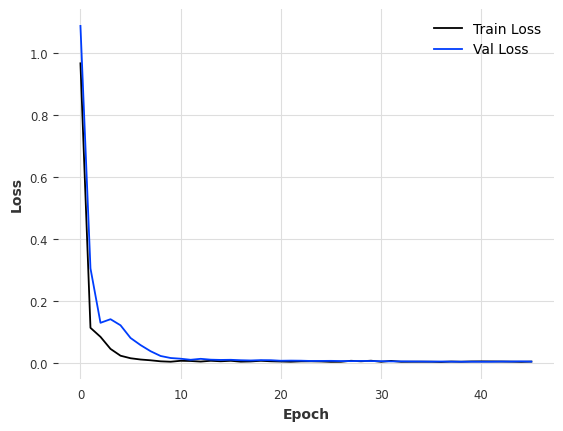

In [38]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
len(val)

72

In [40]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                      | 0/? [00:00<?, ?it/s]

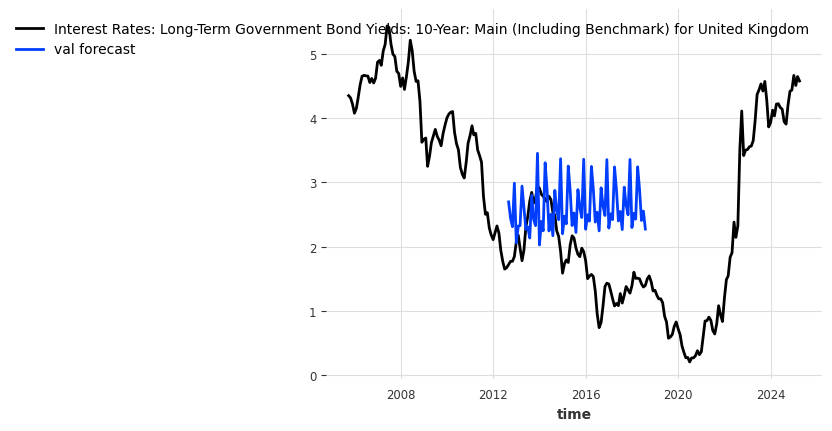

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
from darts.models import NaiveSeasonal

In [43]:
base_model = NaiveSeasonal(K=1)

In [44]:
base_model.model_name = "Baseline"

In [45]:
def backtest_models(
    series: TimeSeries, 
    models: list, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=False, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=retrain,
                    verbose=verbose,
                )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {
            str(model.model_name): (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

In [46]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [48]:
results = backtest_models(
    series, 
    models=models, 
    metrics=metrics,
    points_to_test=len(test)
)

Backtesting 1 <MonthBegin> horizon
Backtesting NBEATS


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting NBEATS


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting NBEATS


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

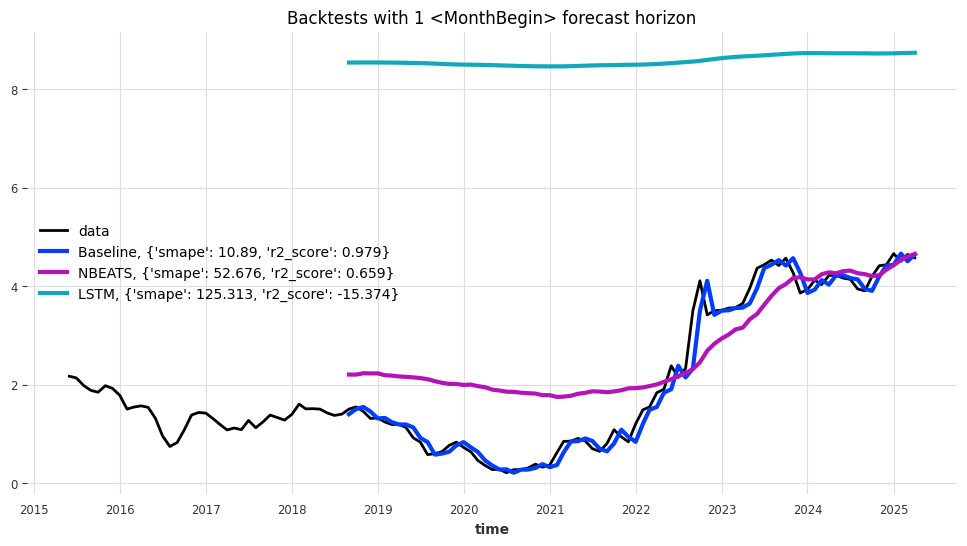

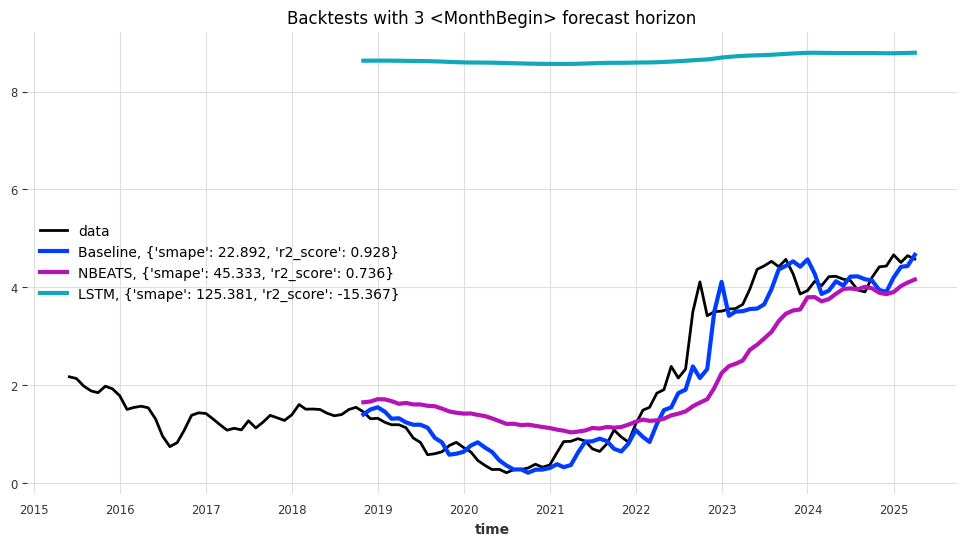

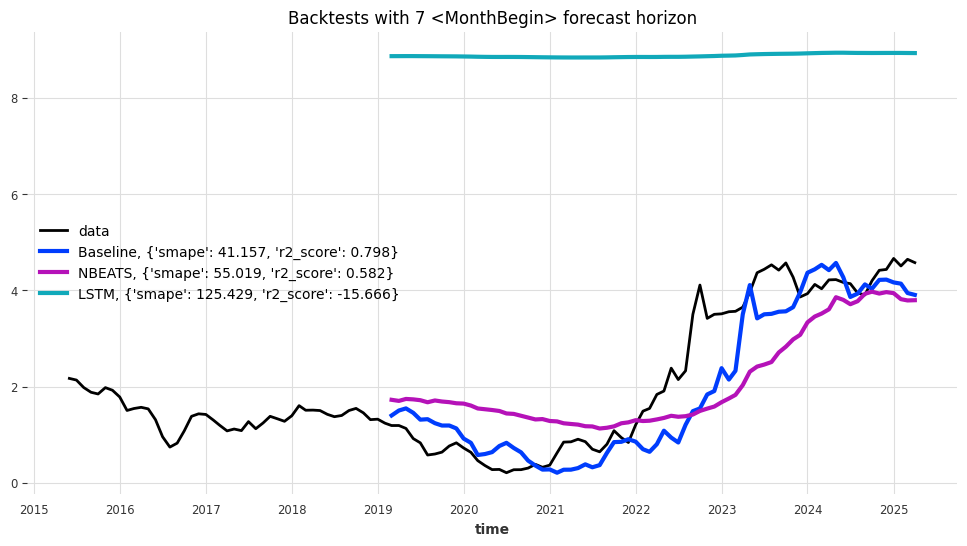

In [49]:
plot_backtest_results(series, results, points_to_test=len(test))

In [50]:
import optuna

In [64]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [65]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "batch_size": 2 ** trial.suggest_int("log2(batch_size)", 4, 8),  # will be a power of two
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] != 1:
        params["dropout"] = trial.suggest_float("dropout", 0, 0.3)
        
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    backtests = backtest_models(
        series[train.time_index.union(val.time_index)], 
        models=[model], 
        horizons=[1, 2, 3, 5, 7],
        metrics=metrics,
        points_to_test=len(val),
    )
    results = [model_dict[params["model"]][1][main_metric.__name__]/(horizon**0.5) 
               for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [70]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{main_metric.__name__}_avghorizons_RNNfamily_study",
    load_if_exists=True
)

[I 2025-05-20 20:29:22,976] A new study created in Journal with name: Interest_Rates_smape_avghorizons_RNNfamily_study


In [71]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=1000, n_jobs=1)  # , timeout=30)

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:25,993] Trial 0 finished with value: 76.65661572753507 and parameters: {'model': 'RNN', 'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 7, 'learning_rate': 0.0003897526710894836}. Best is trial 0 with value: 76.65661572753507.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:28,001] Trial 1 finished with value: 71.45908037087686 and parameters: {'model': 'LSTM', 'hidden_dim': 49, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 4, 'learning_rate': 0.0015286428823225444}. Best is trial 1 with value: 71.45908037087686.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:32,107] Trial 2 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 5, 'n_rnn_layers': 5, 'log2(batch_size)': 4, 'input_chunk_length': 4, 'learning_rate': 1.2389344074910258e-05, 'dropout': 0.08000672019862855}. Best is trial 1 with value: 71.45908037087686.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:34,196] Trial 3 finished with value: 34.876423711386096 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 4, 'learning_rate': 7.197942863728117e-05, 'dropout': 0.2803099288279181}. Best is trial 3 with value: 34.876423711386096.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:36,292] Trial 4 finished with value: 43.806469594452125 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 1, 'learning_rate': 0.00020159762703706016}. Best is trial 3 with value: 34.876423711386096.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:38,890] Trial 5 finished with value: 17.461426628291242 and parameters: {'model': 'RNN', 'hidden_dim': 32, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 9, 'learning_rate': 2.3339660168949222e-05, 'dropout': 0.2094652734153114}. Best is trial 5 with value: 17.461426628291242.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:41,361] Trial 6 finished with value: 80.35410550572345 and parameters: {'model': 'GRU', 'hidden_dim': 5, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 6, 'learning_rate': 0.000665569418618436, 'dropout': 0.15537228839685072}. Best is trial 5 with value: 17.461426628291242.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:44,387] Trial 7 finished with value: 81.64136352532492 and parameters: {'model': 'LSTM', 'hidden_dim': 6, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 0.00042410462249152536, 'dropout': 0.013863213411750896}. Best is trial 5 with value: 17.461426628291242.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:47,246] Trial 8 finished with value: 16.86038937582171 and parameters: {'model': 'LSTM', 'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 3, 'learning_rate': 2.4047647148968262e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:49,421] Trial 9 finished with value: 80.96233285101502 and parameters: {'model': 'LSTM', 'hidden_dim': 41, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.0006841151945082292, 'dropout': 0.19729472307053295}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:52,665] Trial 10 finished with value: 38.65565145089011 and parameters: {'model': 'LSTM', 'hidden_dim': 20, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 18, 'learning_rate': 0.010178999645087998, 'dropout': 0.2913653299351072}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:55,477] Trial 11 finished with value: 59.14605013158503 and parameters: {'model': 'RNN', 'hidden_dim': 26, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 11, 'learning_rate': 1.2714607333501882e-05, 'dropout': 0.19573904240182646}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:29:58,110] Trial 12 finished with value: 68.6733591009476 and parameters: {'model': 'RNN', 'hidden_dim': 19, 'n_rnn_layers': 3, 'log2(batch_size)': 5, 'input_chunk_length': 11, 'learning_rate': 5.124566567331483e-05, 'dropout': 0.2288244951333892}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:00,224] Trial 13 finished with value: 66.7850749072046 and parameters: {'model': 'RNN', 'hidden_dim': 33, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 1, 'learning_rate': 0.03718427351649648, 'dropout': 0.10541153523842585}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:03,170] Trial 14 finished with value: 77.84106829087587 and parameters: {'model': 'RNN', 'hidden_dim': 42, 'n_rnn_layers': 2, 'log2(batch_size)': 4, 'input_chunk_length': 14, 'learning_rate': 5.1799918771387736e-05, 'dropout': 0.11544297196024023}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:06,077] Trial 15 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 1.1040509678677563e-05, 'dropout': 0.23687496298624236}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:08,187] Trial 16 finished with value: 75.22710076122063 and parameters: {'model': 'RNN', 'hidden_dim': 17, 'n_rnn_layers': 3, 'log2(batch_size)': 7, 'input_chunk_length': 13, 'learning_rate': 0.0026991057686184343, 'dropout': 0.029145838753234482}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:12,122] Trial 17 finished with value: 66.98485443989102 and parameters: {'model': 'LSTM', 'hidden_dim': 50, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 6, 'learning_rate': 0.00012429142028439619, 'dropout': 0.17185006014199763}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:14,210] Trial 18 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 41, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 17, 'learning_rate': 3.2425247649876946e-05, 'dropout': 0.24916637315397416}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:16,810] Trial 19 finished with value: 53.861760235564816 and parameters: {'model': 'GRU', 'hidden_dim': 12, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 3, 'learning_rate': 0.0038481174808084008}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:19,130] Trial 20 finished with value: 83.38878412673242 and parameters: {'model': 'LSTM', 'hidden_dim': 26, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 9, 'learning_rate': 0.08413691094917244, 'dropout': 0.059370440273087674}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:21,232] Trial 21 finished with value: 22.587286605291464 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 4, 'learning_rate': 9.61911243241766e-05, 'dropout': 0.29914882861202086}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:23,260] Trial 22 finished with value: 20.66510430669709 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 3.5343115157981584e-05, 'dropout': 0.2628852523340359}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:25,250] Trial 23 finished with value: 26.761984588898173 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 2.5504906262335682e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:27,870] Trial 24 finished with value: 34.85649266979466 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.4957993625924918e-05, 'dropout': 0.2583958629968084}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:29,978] Trial 25 finished with value: 74.69767896987057 and parameters: {'model': 'RNN', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 3, 'learning_rate': 0.00021569225379824397}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:32,318] Trial 26 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 22, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 1, 'learning_rate': 2.542210140798701e-05, 'dropout': 0.21978201995078828}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:34,749] Trial 27 finished with value: 77.20740897687895 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 5, 'input_chunk_length': 5, 'learning_rate': 0.00014792488119393213, 'dropout': 0.19667444144958254}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:36,715] Trial 28 finished with value: 41.22861515778615 and parameters: {'model': 'LSTM', 'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 8, 'learning_rate': 4.350770483084209e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:39,484] Trial 29 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 1.6099145466294842e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:41,691] Trial 30 finished with value: 61.21147358107645 and parameters: {'model': 'RNN', 'hidden_dim': 22, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 0.0002349322684818382, 'dropout': 0.1334127693198974}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:43,791] Trial 31 finished with value: 21.322999314953893 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 3, 'learning_rate': 8.243974015576274e-05, 'dropout': 0.29680854590330913}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:45,903] Trial 32 finished with value: 18.004357085999896 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 3, 'learning_rate': 8.234878517282599e-05, 'dropout': 0.2636421813615654}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:47,872] Trial 33 finished with value: 19.809257454266334 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.98827822369537e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:49,915] Trial 34 finished with value: 21.74370984993172 and parameters: {'model': 'GRU', 'hidden_dim': 48, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 1.7915560151481074e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:51,905] Trial 35 finished with value: 18.458668974052863 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 6.195011497271294e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:53,891] Trial 36 finished with value: 26.717321501503058 and parameters: {'model': 'LSTM', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 7, 'learning_rate': 6.726464082353973e-05}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:56,021] Trial 37 finished with value: 28.31470499555711 and parameters: {'model': 'GRU', 'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 0.00037328200856448306}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:30:58,293] Trial 38 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 40, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 8, 'learning_rate': 1.000303362392826e-05, 'dropout': 0.16246576698867957}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:00,840] Trial 39 finished with value: 61.22358228626926 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 0.0003149431981791563, 'dropout': 0.21266914931889902}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:02,890] Trial 40 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 12, 'learning_rate': 0.00012989395445903775}. Best is trial 8 with value: 16.86038937582171.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:04,858] Trial 41 finished with value: 16.70497090763994 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.7710478111152077e-05}. Best is trial 41 with value: 16.70497090763994.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:06,828] Trial 42 finished with value: 16.388918619336074 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 4.7880131047835014e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:08,803] Trial 43 finished with value: 44.856657205819694 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 0.0010059678602991897}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:10,842] Trial 44 finished with value: 102.6865223639762 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.7869623850024305e-05, 'dropout': 0.18026254346309503}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:12,844] Trial 45 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.291713589609714e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:15,042] Trial 46 finished with value: 30.73104053168484 and parameters: {'model': 'RNN', 'hidden_dim': 34, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 2.0366497543073206e-05, 'dropout': 0.27213667003449477}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:19,396] Trial 47 finished with value: 75.5198189135007 and parameters: {'model': 'LSTM', 'hidden_dim': 47, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 16, 'learning_rate': 5.071939347575401e-05, 'dropout': 0.09292526973867232}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:21,403] Trial 48 finished with value: 44.556252719079865 and parameters: {'model': 'RNN', 'hidden_dim': 40, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 1, 'learning_rate': 9.239681995414331e-05, 'dropout': 0.0652208610590331}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:23,957] Trial 49 finished with value: 25.16029635127024 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 7, 'learning_rate': 3.154004696405854e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:28,122] Trial 50 finished with value: 56.87644617079318 and parameters: {'model': 'LSTM', 'hidden_dim': 50, 'n_rnn_layers': 5, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 0.007761836762942252, 'dropout': 0.1405448439718921}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:30,124] Trial 51 finished with value: 25.254307875674083 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 6.182866235887222e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:32,248] Trial 52 finished with value: 16.393478593248712 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 1.4509704254542859e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:34,409] Trial 53 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 3, 'learning_rate': 1.5156431747097948e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:36,538] Trial 54 finished with value: 16.466517276156214 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 1.2142865853196894e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:38,693] Trial 55 finished with value: 123.31960475541432 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 1.1152431947440423e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:40,992] Trial 56 finished with value: 55.30103981304336 and parameters: {'model': 'RNN', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 6, 'learning_rate': 2.646501719957675e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:43,908] Trial 57 finished with value: 119.31769586614428 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 4, 'log2(batch_size)': 5, 'input_chunk_length': 4, 'learning_rate': 1.5579985751520223e-05, 'dropout': 0.04863991073250491}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:46,223] Trial 58 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 8, 'learning_rate': 1.003190084505991e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:48,370] Trial 59 finished with value: 123.79313211549247 and parameters: {'model': 'RNN', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 2, 'learning_rate': 2.123504656536383e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:51,847] Trial 60 finished with value: 30.516434200219777 and parameters: {'model': 'LSTM', 'hidden_dim': 25, 'n_rnn_layers': 3, 'log2(batch_size)': 4, 'input_chunk_length': 7, 'learning_rate': 3.591073704906043e-05, 'dropout': 0.0025706549478167195}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:54,058] Trial 61 finished with value: 38.11993991722466 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 3, 'learning_rate': 4.801870223801119e-05, 'dropout': 0.24566352277981895}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:56,323] Trial 62 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 3, 'learning_rate': 2.973847373744626e-05, 'dropout': 0.21715088744418812}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:31:58,440] Trial 63 finished with value: 16.572395389924537 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 1.8094190673251514e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:00,609] Trial 64 finished with value: 18.589239122377645 and parameters: {'model': 'GRU', 'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 6, 'learning_rate': 1.4013984320731346e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:02,973] Trial 65 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 5, 'learning_rate': 1.9740550956267185e-05}. Best is trial 42 with value: 16.388918619336074.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:05,010] Trial 66 finished with value: 15.93806232294646 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.4908752318485784e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:07,000] Trial 67 finished with value: 27.02742061212271 and parameters: {'model': 'GRU', 'hidden_dim': 49, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.4641241477376536e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:08,977] Trial 68 finished with value: 16.43334371056128 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 4.311034984147875e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:11,040] Trial 69 finished with value: 16.465200194901026 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 4.015550225735259e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:13,069] Trial 70 finished with value: 26.453916603862062 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 3.7785198977115564e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:15,063] Trial 71 finished with value: 16.61168414143966 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.647810172573543e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:17,029] Trial 72 finished with value: 104.35454537237429 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.710883012303133e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:18,976] Trial 73 finished with value: 18.522382391195094 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 0.0001582927592030852}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:20,911] Trial 74 finished with value: 39.41608950477284 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 4.6808814956560206e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:22,863] Trial 75 finished with value: 18.37434829017726 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.00010556314331488095}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:25,454] Trial 76 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.427039907504914e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:27,427] Trial 77 finished with value: 16.253831433454685 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 6.703464245632456e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:29,424] Trial 78 finished with value: 16.352455787436902 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 6.958827687611759e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:31,381] Trial 79 finished with value: 16.540612068755877 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 7.420990331874856e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:33,364] Trial 80 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 5.7780840980366745e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:35,332] Trial 81 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.0001844418634437701}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:37,293] Trial 82 finished with value: 19.758564343807244 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 7.83444724728355e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:39,247] Trial 83 finished with value: 50.11760941463128 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.00012158197842750144}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:41,214] Trial 84 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 7.067689697605326e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:43,174] Trial 85 finished with value: 25.0683664209416 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 3.843450898579302e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:45,096] Trial 86 finished with value: 40.29069585148974 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.00026714307692837026}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:47,078] Trial 87 finished with value: 78.42980811691419 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 0.0017130558369808562, 'dropout': 0.03142839969109694}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:49,084] Trial 88 finished with value: 65.45336895039489 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.029453563399405077}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:51,071] Trial 89 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.4513578684229495e-05}. Best is trial 66 with value: 15.93806232294646.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:53,055] Trial 90 finished with value: 15.869059645208333 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 6.07964537936861e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:55,017] Trial 91 finished with value: 17.165641785079295 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 9.397553400326233e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:56,990] Trial 92 finished with value: 47.05222706591005 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 6.102454613514925e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:32:58,946] Trial 93 finished with value: 76.58281468875802 and parameters: {'model': 'GRU', 'hidden_dim': 15, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 3.290923094709237e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:00,942] Trial 94 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 0.00012023731562741242}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:02,897] Trial 95 finished with value: 28.696515747706876 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 7.833233150034629e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:04,850] Trial 96 finished with value: 21.319760914293074 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.0005685688199470317}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:06,817] Trial 97 finished with value: 27.774969412462745 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 5.3759954191423044e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:08,822] Trial 98 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 21, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 6, 'learning_rate': 4.3862961907258335e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:10,759] Trial 99 finished with value: 37.121883031118855 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.2981387674287273e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:12,802] Trial 100 finished with value: 21.76500699538456 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 2.1835471006717234e-05, 'dropout': 0.12537608596934588}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:15,437] Trial 101 finished with value: 16.506755804478257 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 3.173143965599441e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:17,542] Trial 102 finished with value: 25.433574220684417 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 3.188693114473766e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:19,533] Trial 103 finished with value: 18.55530070741321 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 7, 'learning_rate': 6.734416190201457e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:21,468] Trial 104 finished with value: 22.36270514529283 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 4.083380790498573e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:23,472] Trial 105 finished with value: 111.41432704418568 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.1938159244587523e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:25,523] Trial 106 finished with value: 105.71460090582214 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 6, 'learning_rate': 5.409863061719075e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:27,680] Trial 107 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 1.720299444926741e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:29,793] Trial 108 finished with value: 17.0469337459018 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 0.00010209573180296834}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:31,841] Trial 109 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 7, 'learning_rate': 2.4612653103856973e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:33,820] Trial 110 finished with value: 35.83239464623839 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 0.00016831368801104997}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:35,850] Trial 111 finished with value: 16.562729892986848 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 1.864022170940127e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:37,983] Trial 112 finished with value: 71.55041931252993 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 3.0005231243549813e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:39,933] Trial 113 finished with value: 19.416621731694782 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 2.1073391583228784e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:41,906] Trial 114 finished with value: 16.505571789128627 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.646410497863689e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:43,868] Trial 115 finished with value: 16.118142876699665 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.7898171170310695e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:45,837] Trial 116 finished with value: 16.09103561846708 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.486113662461133e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:47,793] Trial 117 finished with value: 25.497885326754464 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.748940432599951e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:49,750] Trial 118 finished with value: 18.091556299757972 and parameters: {'model': 'RNN', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.728753842839809e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:51,799] Trial 119 finished with value: 41.244118625620786 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 6.15657908591772e-05, 'dropout': 0.08336977080606124}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:53,801] Trial 120 finished with value: 17.062274136661735 and parameters: {'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.9129239026103162e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:55,773] Trial 121 finished with value: 16.116701522347775 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.7768025114541037e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:57,723] Trial 122 finished with value: 27.236022580780524 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.160740057686134e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:33:59,696] Trial 123 finished with value: 16.654441784304943 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.2976377984032296e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:01,676] Trial 124 finished with value: 91.07500742465747 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 5.329980259173845e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:03,634] Trial 125 finished with value: 16.169012889836115 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.4394485911358174e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:05,569] Trial 126 finished with value: 21.718708508443235 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.6532451959452618e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:07,528] Trial 127 finished with value: 16.25561299079454 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1289854671239702e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:10,074] Trial 128 finished with value: 16.218392357395683 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.40975432561981e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:12,009] Trial 129 finished with value: 22.784379141766195 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0669155066288473e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:13,978] Trial 130 finished with value: 16.249374515457724 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.436153899564021e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:15,949] Trial 131 finished with value: 16.263467515725978 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3313169999012054e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:17,919] Trial 132 finished with value: 16.270811674669275 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.450326349496737e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:19,854] Trial 133 finished with value: 37.500901264840266 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4914360484291826e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:21,814] Trial 134 finished with value: 16.306646449526394 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.0073778437825579e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:23,789] Trial 135 finished with value: 16.26141149908761 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3461426369738859e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:25,767] Trial 136 finished with value: 16.34572172933961 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.0027651982879891e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:27,745] Trial 137 finished with value: 16.29329135344137 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.281487553864455e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:29,697] Trial 138 finished with value: 25.691616467972995 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2961911424615137e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:31,632] Trial 139 finished with value: 22.98653780420717 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3438457612470408e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:33,614] Trial 140 finished with value: 16.21768623115802 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.6741336531032463e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:35,589] Trial 141 finished with value: 16.21617654864883 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.6850210328960885e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:37,550] Trial 142 finished with value: 25.968373272994672 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7636430176664715e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:39,481] Trial 143 finished with value: 23.344605631035765 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.0127219802442444e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:41,437] Trial 144 finished with value: 19.494908685412856 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4850521734289491e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:43,409] Trial 145 finished with value: 16.207714277250393 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.747804013449383e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:45,390] Trial 146 finished with value: 94.86510011559614 and parameters: {'model': 'RNN', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.4703175886833236e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:47,341] Trial 147 finished with value: 25.958284418084652 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.7435956629514924e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:49,345] Trial 148 finished with value: 17.22784101889106 and parameters: {'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.1211426342636966e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:51,289] Trial 149 finished with value: 46.67791254786564 and parameters: {'model': 'GRU', 'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1479395792743097e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:53,353] Trial 150 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.6404977123137337e-05, 'dropout': 0.10362771345491625}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:55,328] Trial 151 finished with value: 16.279287795892213 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3865214056525664e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:57,270] Trial 152 finished with value: 26.05613572458181 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.9223089482545985e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:34:59,225] Trial 153 finished with value: 16.099071325383626 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.602995614544159e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:01,148] Trial 154 finished with value: 23.544224813947523 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.380726040591489e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:03,938] Trial 155 finished with value: 65.82269635289201 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.868698859211846e-05, 'dropout': 0.1539685867007258}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:05,894] Trial 156 finished with value: 19.353593983129063 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2088274940047205e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:07,883] Trial 157 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.085749527437284e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:09,833] Trial 158 finished with value: 19.58857151986781 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.619968564395543e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:11,788] Trial 159 finished with value: 26.36798227744098 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.490271387579778e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:13,756] Trial 160 finished with value: 25.478417103398947 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.9044194919846013e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:15,740] Trial 161 finished with value: 16.274403401151567 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4225478768032632e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:17,722] Trial 162 finished with value: 16.306291685451274 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1838342445529928e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:19,668] Trial 163 finished with value: 23.193030176167916 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7349107848894907e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:21,635] Trial 164 finished with value: 19.47449659717161 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4754408459753977e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:23,602] Trial 165 finished with value: 16.14388538555897 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.9809202227048532e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:25,589] Trial 166 finished with value: 23.400115702394963 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.1975624338076063e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:27,567] Trial 167 finished with value: 72.94602170415308 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.005789022158494402}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:29,566] Trial 168 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.996597428409805e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:31,536] Trial 169 finished with value: 16.02932660285685 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 3.485582054161654e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:33,499] Trial 170 finished with value: 26.77588307282271 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 3.2493974075639066e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:35,479] Trial 171 finished with value: 16.090407276996558 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.6908427656526688e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:37,467] Trial 172 finished with value: 16.522251589383632 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 3.503685247360719e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:39,427] Trial 173 finished with value: 26.49426848876693 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.721465586970423e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:41,359] Trial 174 finished with value: 74.20242115876468 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.09757040744785259}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:43,324] Trial 175 finished with value: 20.06195632174364 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 18, 'learning_rate': 2.4485540482893643e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:45,270] Trial 176 finished with value: 48.449656705528646 and parameters: {'model': 'RNN', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 3.4618845811731004e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:47,229] Trial 177 finished with value: 24.217990017074698 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.9203868868854844e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:49,161] Trial 178 finished with value: 65.13647994187794 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.0010694933646759799}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:51,136] Trial 179 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.7827809750563412e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:53,099] Trial 180 finished with value: 94.0417552872194 and parameters: {'model': 'GRU', 'hidden_dim': 17, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.6965006207422472e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:55,059] Trial 181 finished with value: 16.300026344941827 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.0567959353640039e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:57,611] Trial 182 finished with value: 25.665971095545995 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2197014902151235e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:35:59,529] Trial 183 finished with value: 23.4199694193066 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 2.1511339925061123e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:01,497] Trial 184 finished with value: 16.18471388491925 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.6622588951645097e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:03,465] Trial 185 finished with value: 19.641051518677724 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.71208945024365e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:05,427] Trial 186 finished with value: 26.506648739146538 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.7506420540746402e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:07,387] Trial 187 finished with value: 23.988104872516256 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.300549269363273e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:09,330] Trial 188 finished with value: 70.0749539667377 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.027218165857023614}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:11,300] Trial 189 finished with value: 16.148720920540388 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.056975667365278e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:13,263] Trial 190 finished with value: 21.54401960058636 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.587023695024705e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:15,242] Trial 191 finished with value: 16.123355583735062 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.839082424342538e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:17,197] Trial 192 finished with value: 27.249580568198223 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.183470454326244e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:19,170] Trial 193 finished with value: 16.088966051800195 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.4575068859951466e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:21,110] Trial 194 finished with value: 24.041101466430003 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.5900330313997534e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:23,071] Trial 195 finished with value: 22.054634116034606 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 5.325167980819405e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:25,055] Trial 196 finished with value: 26.47750862337221 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 3.3011444296579365e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:27,017] Trial 197 finished with value: 27.19000810561061 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 4.082691145306614e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:28,996] Trial 198 finished with value: 16.075974468635224 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.7441309325681675e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:30,960] Trial 199 finished with value: 16.08143676528749 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.106992952170426e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:32,933] Trial 200 finished with value: 16.564502002045085 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.106735111217333e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:34,939] Trial 201 finished with value: 16.10203084714133 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.9420468144311685e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:36,918] Trial 202 finished with value: 16.106455016429432 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.971037818916337e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:38,908] Trial 203 finished with value: 22.285267877135865 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.631199309591529e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:40,905] Trial 204 finished with value: 16.032686276703508 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.4673847419573516e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:42,870] Trial 205 finished with value: 25.04139277326157 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.9408752586726986e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:44,885] Trial 206 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 4.082807109798585e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:46,862] Trial 207 finished with value: 27.56550209933718 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.655088229335233e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:48,828] Trial 208 finished with value: 16.293931792875252 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 6.099200781345024e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:51,463] Trial 209 finished with value: 16.50006626610358 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.659086501300179e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:53,443] Trial 210 finished with value: 124.30581807208065 and parameters: {'model': 'RNN', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.870777857975501e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:55,418] Trial 211 finished with value: 16.064276482446594 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.2955303757946075e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:57,373] Trial 212 finished with value: 26.703784279880665 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.215514627710921e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:36:59,329] Trial 213 finished with value: 21.082162380626055 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.928016822418741e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:01,300] Trial 214 finished with value: 16.119610285431847 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.8126812296516798e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:03,255] Trial 215 finished with value: 26.509537301342483 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.861882927620489e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:05,191] Trial 216 finished with value: 24.268760028543564 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.684065509954171e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:07,171] Trial 217 finished with value: 16.03291550093546 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.440789166925621e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:09,163] Trial 218 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.35343842931209e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:11,369] Trial 219 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 8.200510584651524e-05, 'dropout': 0.18352960802788426}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:13,323] Trial 220 finished with value: 26.611424835845362 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 4.322212589580655e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:15,313] Trial 221 finished with value: 20.5224579309138 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.103342999802018e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:17,282] Trial 222 finished with value: 16.044827830400568 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.534068960257156e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:19,242] Trial 223 finished with value: 26.93381680186086 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.607986158698457e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:21,229] Trial 224 finished with value: 16.047916497467856 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.5834117028017094e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:23,208] Trial 225 finished with value: 22.71066033309299 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.237413070950273e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:25,153] Trial 226 finished with value: 24.846697082050408 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.634197185522639e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:27,137] Trial 227 finished with value: 16.016653545252282 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.2169224747208774e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:29,121] Trial 228 finished with value: 16.433223327734506 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 4.224802810642189e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:31,076] Trial 229 finished with value: 27.988672700958126 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.301817539811184e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:33,049] Trial 230 finished with value: 16.058228901976666 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.3043583185849013e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:35,023] Trial 231 finished with value: 16.050377315976384 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.397947181621986e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:37,140] Trial 232 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.163984659657663e-05, 'dropout': 0.03230511687437525}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:39,119] Trial 233 finished with value: 16.1035134235357 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.8591664111338748e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:41,075] Trial 234 finished with value: 26.4218804078531 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6679097930167176e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:43,012] Trial 235 finished with value: 24.189132081909698 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.5104326734754996e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:44,990] Trial 236 finished with value: 16.106570964757022 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.880335234603053e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:47,570] Trial 237 finished with value: 20.329184985945602 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.8264710268193136e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:49,530] Trial 238 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.2406205008256696e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:51,531] Trial 239 finished with value: 16.376333776994052 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.790582119274705e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:53,483] Trial 240 finished with value: 26.39385381462389 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6167406885132743e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:55,635] Trial 241 finished with value: 75.52404348643104 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.854590074417098e-05, 'dropout': 0.06956756490892535}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:57,617] Trial 242 finished with value: 16.049564264891256 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.4502561484054844e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:37:59,595] Trial 243 finished with value: 16.068514562672103 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.22626875664872e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:01,583] Trial 244 finished with value: 20.728329654458726 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.409469621378864e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:03,525] Trial 245 finished with value: 24.852932561042433 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.631396049028913e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:05,493] Trial 246 finished with value: 29.057603668520102 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 6.804451178236538e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:07,463] Trial 247 finished with value: 22.25346418048276 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.5833483368857505e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:09,433] Trial 248 finished with value: 26.71683411633752 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.2251176764195986e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:11,413] Trial 249 finished with value: 16.0189014069781 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.0292020261303946e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:13,413] Trial 250 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.2478687305184624e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:15,453] Trial 251 finished with value: 20.193629918342204 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.6083776030449767e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:17,441] Trial 252 finished with value: 16.09857002623324 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.918129665569928e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:19,413] Trial 253 finished with value: 16.091987468728366 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.874692761737673e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:21,374] Trial 254 finished with value: 106.6283051650285 and parameters: {'model': 'RNN', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.975938516801668e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:23,331] Trial 255 finished with value: 27.797557453970548 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 5.0352339272355925e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:25,311] Trial 256 finished with value: 16.414511549109513 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 7.026249190086664e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:27,285] Trial 257 finished with value: 43.155120268141275 and parameters: {'model': 'LSTM', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.741825843284771e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:29,264] Trial 258 finished with value: 16.019158298388174 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 4.0364535412793835e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:31,224] Trial 259 finished with value: 17.06807926822014 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.8862295522358634e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:33,192] Trial 260 finished with value: 20.81718554753811 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.542137287294818e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:35,146] Trial 261 finished with value: 27.27125169015356 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.176956307593033e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:37,126] Trial 262 finished with value: 16.648312633299827 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 2.3791272056057508e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:39,084] Trial 263 finished with value: 79.81736038111289 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.002744004508786826}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:41,065] Trial 264 finished with value: 25.485127825696313 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 5.697082973798296e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:44,404] Trial 265 finished with value: 48.110799389624574 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 13, 'learning_rate': 3.089252680702892e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:46,430] Trial 266 finished with value: 16.040536998304027 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.564266346273847e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:48,420] Trial 267 finished with value: 27.409714637772037 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.401647967576028e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:50,356] Trial 268 finished with value: 38.9634644419853 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.431149723424179e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:52,355] Trial 269 finished with value: 89.09872151267862 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.7298555532747726e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:54,316] Trial 270 finished with value: 21.42457271395919 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.419783675168199e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:56,306] Trial 271 finished with value: 16.48935289083972 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 3.742075266084586e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:38:58,264] Trial 272 finished with value: 26.65856798100254 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 7.666129113844216e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:00,282] Trial 273 finished with value: 16.06431144683289 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.3077356572928446e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:02,286] Trial 274 finished with value: 16.177534949486724 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 2.4082522153516863e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:04,281] Trial 275 finished with value: 26.716036724328223 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.2477804206414266e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:06,697] Trial 276 finished with value: 71.99473443102211 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 12, 'learning_rate': 0.0004570004104486372}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:08,748] Trial 277 finished with value: 16.911318141244255 and parameters: {'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.7789975810782804e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:10,822] Trial 278 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.5348378173317425e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:12,811] Trial 279 finished with value: 25.725538021873216 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.0247606645048862e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:14,848] Trial 280 finished with value: 16.01772179569631 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.0404159215208103e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:16,860] Trial 281 finished with value: 21.29743860242224 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.236336183219304e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:18,837] Trial 282 finished with value: 25.152828328911472 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.124388460229175e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:20,857] Trial 283 finished with value: 16.53151386078207 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.395330289273497e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:22,844] Trial 284 finished with value: 16.016449383828412 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.2593396050838626e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:24,833] Trial 285 finished with value: 92.05776155408537 and parameters: {'model': 'GRU', 'hidden_dim': 2, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 3.7783800470569224e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:26,824] Trial 286 finished with value: 26.644243454602275 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.092494392851905e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:28,813] Trial 287 finished with value: 16.43256152355149 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.2359965093058094e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:30,855] Trial 288 finished with value: 16.300494884032112 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 6.049902994430417e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:32,877] Trial 289 finished with value: 20.764874669525245 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.47827189628276e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:34,904] Trial 290 finished with value: 27.258683797536992 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 4.138033472309102e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:36,855] Trial 291 finished with value: 23.783881132265257 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.8430321236415246e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:38,841] Trial 292 finished with value: 16.176152126388295 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.3730738268600047e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:40,924] Trial 293 finished with value: 21.49385140353062 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.523539008340565e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:43,613] Trial 294 finished with value: 39.09704954747946 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.612972047714575e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:45,705] Trial 295 finished with value: 63.32901417707846 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 0.017450282351751716}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:47,756] Trial 296 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 19, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 5.995108820417208e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:49,949] Trial 297 finished with value: 30.656252858668598 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.0466547694074242e-05, 'dropout': 0.0015559686859566713}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:52,026] Trial 298 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.9967560589516666e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:54,766] Trial 299 finished with value: 16.472138905323742 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.9109505721883513e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:56,943] Trial 300 finished with value: 20.556137212299294 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.1655347508051815e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:39:59,088] Trial 301 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.322466161809709e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:01,218] Trial 302 finished with value: 28.99578663279856 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.733692953330869e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:03,313] Trial 303 finished with value: 25.156448818377054 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.199141090056286e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:05,475] Trial 304 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 2.6325618374663906e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:07,626] Trial 305 finished with value: 21.62234269950872 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.519932014153562e-05, 'dropout': 0.27802188695733154}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:09,702] Trial 306 finished with value: 25.15931667503495 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 5.121304010217613e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:11,770] Trial 307 finished with value: 43.8797035291816 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 9.241438092065911e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:13,812] Trial 308 finished with value: 21.15001270581781 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 4.032592861974574e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:15,844] Trial 309 finished with value: 16.11182191969432 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.8689487916817076e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:17,904] Trial 310 finished with value: 26.866052042632703 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.5132586589885736e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:19,965] Trial 311 finished with value: 16.339931315346377 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.344628516212201e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:21,963] Trial 312 finished with value: 24.709505627015567 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.4104840080446406e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:23,983] Trial 313 finished with value: 20.063161838342527 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.4303596258853114e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:26,053] Trial 314 finished with value: 16.06783324454259 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.2559442025557376e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:28,064] Trial 315 finished with value: 26.604200247921305 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.0195101332851457e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:30,117] Trial 316 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 3.5247633253905534e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:32,230] Trial 317 finished with value: 48.613288485152424 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 2.3613891474022053e-05, 'dropout': 0.05176601118927833}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:34,494] Trial 318 finished with value: 17.798226361726492 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.8014566335942396e-05, 'dropout': 0.23047916579870803}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:36,536] Trial 319 finished with value: 16.056793287779122 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 3.263264914595394e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:38,646] Trial 320 finished with value: 26.725899465752093 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 3.197437685246882e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:40,656] Trial 321 finished with value: 23.691121265810942 and parameters: {'model': 'RNN', 'hidden_dim': 14, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.0008213970436099799}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:43,575] Trial 322 finished with value: 16.459419078981377 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.012649841512941e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:45,658] Trial 323 finished with value: 16.13227253688519 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6488268985450993e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:47,732] Trial 324 finished with value: 54.287081456534864 and parameters: {'model': 'LSTM', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.383510245918523e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:49,756] Trial 325 finished with value: 21.198187108915075 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 4.0874759526863273e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:51,806] Trial 326 finished with value: 16.191473491036223 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.28772945520023e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:53,862] Trial 327 finished with value: 88.03600423662598 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 5.958298138407853e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:55,946] Trial 328 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 1, 'learning_rate': 2.9517703338096283e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:40:57,992] Trial 329 finished with value: 16.39268918386626 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 16, 'learning_rate': 4.5873584353131895e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:00,063] Trial 330 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.8864006833523716e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:02,096] Trial 331 finished with value: 26.73051651086062 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.25013191424215e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:04,130] Trial 332 finished with value: 16.211289014857755 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 2.159741765067696e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:06,443] Trial 333 finished with value: 69.69013070509092 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.7136388629154176e-05, 'dropout': 0.11783468194273342}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:08,524] Trial 334 finished with value: 123.74474790116483 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.888135164448269e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:10,609] Trial 335 finished with value: 19.87713164808599 and parameters: {'model': 'GRU', 'hidden_dim': 48, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.0133284022716285e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:12,622] Trial 336 finished with value: 76.54604494954086 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 0.05245939297910516}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:14,643] Trial 337 finished with value: 26.99216830557201 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.734306229224062e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:16,663] Trial 338 finished with value: 16.06880150569554 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.244877141587511e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:18,668] Trial 339 finished with value: 26.66332627673419 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.434217672383184e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:20,694] Trial 340 finished with value: 20.69076941250787 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.365030811904284e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:22,769] Trial 341 finished with value: 28.07016068488832 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.4337210930954274e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:24,884] Trial 342 finished with value: 16.02145333929889 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.930468273161775e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:26,995] Trial 343 finished with value: 16.433764749090745 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.2319027973421837e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:29,124] Trial 344 finished with value: 16.22377416821575 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.713866350100234e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:31,182] Trial 345 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.862877866514746e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:33,194] Trial 346 finished with value: 21.651415142543264 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.742834918383726e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:35,255] Trial 347 finished with value: 54.97935987665706 and parameters: {'model': 'LSTM', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.034893272655912e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:37,353] Trial 348 finished with value: 27.84475782852875 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 0.0002605097946384474}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:39,503] Trial 349 finished with value: 16.450508873337263 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 7.376806212803979e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:41,771] Trial 350 finished with value: 24.317740965717057 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.727028338084859e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:44,732] Trial 351 finished with value: 26.762134968888567 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.4524344697433263e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:46,840] Trial 352 finished with value: 21.563969027619454 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.6195193940912863e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:48,960] Trial 353 finished with value: 16.063574049755275 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.3174121206634774e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:51,127] Trial 354 finished with value: 28.153178322721885 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 6.264460838266076e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:53,705] Trial 355 finished with value: 41.667721546993256 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 14, 'learning_rate': 3.90928046755653e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:55,781] Trial 356 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 2.9380321967896988e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:41:57,923] Trial 357 finished with value: 124.38400475541434 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 5.100016916537989e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:00,050] Trial 358 finished with value: 42.712305198424716 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 15, 'learning_rate': 2.1068217217957077e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:02,150] Trial 359 finished with value: 22.265992936911292 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 11, 'learning_rate': 3.363928903185025e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:04,196] Trial 360 finished with value: 16.029688225197372 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.252106964283969e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:06,264] Trial 361 finished with value: 16.121144599675848 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.661927690016557e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:08,318] Trial 362 finished with value: 27.164954834548503 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 3.961431524884656e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:10,381] Trial 363 finished with value: 50.29548742067751 and parameters: {'model': 'GRU', 'hidden_dim': 22, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 3.344226736397766e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:12,457] Trial 364 finished with value: 16.41683126924231 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 4.366375326749472e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:14,490] Trial 365 finished with value: 82.5679882348542 and parameters: {'model': 'GRU', 'hidden_dim': 10, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.0012143470456168334}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:16,524] Trial 366 finished with value: 23.70902796767269 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 2.6607695389339655e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:18,593] Trial 367 finished with value: 77.77186800422804 and parameters: {'model': 'RNN', 'hidden_dim': 33, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 0.00035165745886054544, 'dropout': 0.28692666528312716}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:20,668] Trial 368 finished with value: 22.232862441960332 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 5.543586323171097e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:22,751] Trial 369 finished with value: 16.061555497198874 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.326561901923595e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:24,808] Trial 370 finished with value: 27.051974092702544 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.838373910685375e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:26,999] Trial 371 finished with value: 84.5452929942556 and parameters: {'model': 'LSTM', 'hidden_dim': 39, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.005348690829211834, 'dropout': 0.20354307605210686}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:29,049] Trial 372 finished with value: 19.802241359512 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.064465768384312e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:31,101] Trial 373 finished with value: 16.03687309041286 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.477110702653451e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:33,126] Trial 374 finished with value: 25.858748342368482 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 6.281320853382723e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:35,215] Trial 375 finished with value: 16.071592567698808 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.740011818821704e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:37,250] Trial 376 finished with value: 25.905463821742142 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 4.415328079150802e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:39,345] Trial 377 finished with value: 124.34440475541433 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.4543657313990865e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:41,384] Trial 378 finished with value: 21.06540618197986 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 14, 'learning_rate': 3.9108284261971714e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:43,436] Trial 379 finished with value: 82.79860858849432 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 0.0017829028680976257}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:45,475] Trial 380 finished with value: 16.041771087918615 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.5480057963311104e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:48,259] Trial 381 finished with value: 29.53757040253866 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 7.433118256031665e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:50,288] Trial 382 finished with value: 16.35026010062513 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.164400987062834e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:52,356] Trial 383 finished with value: 96.25514045014634 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.3138482586359674e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:54,431] Trial 384 finished with value: 16.02756603248881 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.724370322367168e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:56,759] Trial 385 finished with value: 44.80450673812798 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 6.21249747625838e-05, 'dropout': 0.016300514136430494}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:42:59,602] Trial 386 finished with value: 53.97811362174883 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 11, 'learning_rate': 3.8789089605068026e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:01,858] Trial 387 finished with value: 30.607444383909943 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 8.835904967215057e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:03,993] Trial 388 finished with value: 17.21402216477217 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.722746646708315e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:06,117] Trial 389 finished with value: 16.13498544493363 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6294055514987538e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:08,259] Trial 390 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.876414217944887e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:10,478] Trial 391 finished with value: 21.919746170161424 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 5.1100008998677734e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:12,571] Trial 392 finished with value: 23.88856162818046 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.0121951459640477e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:14,672] Trial 393 finished with value: 81.05626539955239 and parameters: {'model': 'LSTM', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.010627969911553537}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:16,803] Trial 394 finished with value: 26.928916978565248 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.599404883815006e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:18,968] Trial 395 finished with value: 16.05990043083575 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.523097804416501e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:21,164] Trial 396 finished with value: 16.423360415381055 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 6.520785216955766e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:23,336] Trial 397 finished with value: 57.994971117907355 and parameters: {'model': 'GRU', 'hidden_dim': 6, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 5.519439210905466e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:25,654] Trial 398 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.489550415431953e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:27,872] Trial 399 finished with value: 21.36270671650373 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 4.3158334244547454e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:30,078] Trial 400 finished with value: 28.114662805032975 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 5.448681218299521e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:32,292] Trial 401 finished with value: 29.204014128973647 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 7.711579312985e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:34,540] Trial 402 finished with value: 22.660519128900344 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 9, 'learning_rate': 3.6966462169883654e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:36,686] Trial 403 finished with value: 24.68055542876507 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 4.3361018551079794e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:38,886] Trial 404 finished with value: 16.0981454739616 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.8374964542378225e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:41,218] Trial 405 finished with value: 16.466065134868344 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 12, 'learning_rate': 2.374761825146973e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:43,415] Trial 406 finished with value: 33.69483315358092 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 16, 'learning_rate': 0.00012904006205331135}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:45,699] Trial 407 finished with value: 16.13511778510931 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 5.095413286832007e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:47,985] Trial 408 finished with value: 16.51461124500897 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.539520235789351e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:50,221] Trial 409 finished with value: 119.28121222588175 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 6.186296515839887e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:53,228] Trial 410 finished with value: 21.378489949860057 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.353016814334351e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:55,389] Trial 411 finished with value: 23.919490486632775 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 3.0363228248978543e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:57,657] Trial 412 finished with value: 21.73334006523308 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.627566910648078e-05, 'dropout': 0.14015046711425297}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:43:59,872] Trial 413 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.8283745750516155e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:02,119] Trial 414 finished with value: 16.585967128350717 and parameters: {'model': 'GRU', 'hidden_dim': 20, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6878408569424464e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:04,325] Trial 415 finished with value: 16.018320108462625 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.0451667662402696e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:06,618] Trial 416 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.842047636397868e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:08,838] Trial 417 finished with value: 21.32680984254693 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.27850811253146e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:11,052] Trial 418 finished with value: 29.015181840589484 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.759542168581123e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:13,260] Trial 419 finished with value: 19.81648997536584 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 2, 'learning_rate': 5.0484802519358814e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:15,478] Trial 420 finished with value: 16.448966619406214 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 4.131017238418352e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:17,707] Trial 421 finished with value: 20.90737157971501 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.679729556208659e-05}. Best is trial 90 with value: 15.869059645208333.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:20,008] Trial 422 finished with value: 15.503652119334223 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.079276676510584e-05}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:22,504] Trial 423 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.1577919302025844e-05, 'dropout': 0.08346166044128595}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:24,766] Trial 424 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.7959825972899558e-05}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:26,989] Trial 425 finished with value: 51.770432017625 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.0005657838743047048}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:29,300] Trial 426 finished with value: 47.44471465593689 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 5.307182614528202e-05, 'dropout': 0.16714912549724892}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:31,582] Trial 427 finished with value: 15.71668054663861 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 4.200996831840692e-05}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:34,021] Trial 428 finished with value: 16.47011826533218 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 11, 'learning_rate': 3.751067069988996e-05}. Best is trial 422 with value: 15.503652119334223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:36,299] Trial 429 finished with value: 15.470432642914048 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.8958290893417806e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:38,520] Trial 430 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.4184420136521928e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:40,734] Trial 431 finished with value: 26.055192998225255 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.9200068916056745e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:42,999] Trial 432 finished with value: 15.714037593076432 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.137312230815684e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:45,694] Trial 433 finished with value: 37.9731784336823 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 12, 'learning_rate': 5.8715515885482034e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:47,930] Trial 434 finished with value: 15.862580070675474 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.662412315480438e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:50,146] Trial 435 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 7.437825171663229e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:52,357] Trial 436 finished with value: 32.06656657718808 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.7874012647466105e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:54,618] Trial 437 finished with value: 16.317521197744735 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.016316258768531e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:56,868] Trial 438 finished with value: 15.750903888031413 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.272526627301402e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:44:59,098] Trial 439 finished with value: 49.31473895050096 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 8.909128578551e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:02,101] Trial 440 finished with value: 33.01744311190954 and parameters: {'model': 'LSTM', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.139047123376216e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:04,280] Trial 441 finished with value: 23.975268170003034 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.2671521814499825e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:06,506] Trial 442 finished with value: 16.408021618753203 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 6.251764460049238e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:08,757] Trial 443 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 0.00011007226380122944}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:10,963] Trial 444 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 4.801549332673162e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:13,173] Trial 445 finished with value: 46.990259466839916 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.1760149101177714e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:15,387] Trial 446 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 5.3598634903909385e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:17,622] Trial 447 finished with value: 15.676282657278279 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.990298825808022e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:19,873] Trial 448 finished with value: 15.634900149082608 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.812978549818801e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:22,103] Trial 449 finished with value: 47.01642103034686 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.228137403124865e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:24,340] Trial 450 finished with value: 24.462199970492975 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.946581937391501e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:26,571] Trial 451 finished with value: 16.45149920353476 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 6.383699456189693e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:28,836] Trial 452 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.072745130133707e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:31,192] Trial 453 finished with value: 20.914494520534102 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 3.900992914684753e-05, 'dropout': 0.18271115570264185}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:33,427] Trial 454 finished with value: 19.53306824032479 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 7.722339238027736e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:35,662] Trial 455 finished with value: 15.471587054242505 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.903013572601084e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:37,873] Trial 456 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 1.935843184820205e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:40,083] Trial 457 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.817533715399314e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:42,374] Trial 458 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.3673291528768033e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:44,601] Trial 459 finished with value: 25.963705482964258 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 2.9781930958790314e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:46,867] Trial 460 finished with value: 31.829698366383003 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 4.591055949361322e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:49,101] Trial 461 finished with value: 39.871157208452914 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 3.906154465709833e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:51,292] Trial 462 finished with value: 47.863938025675026 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 12, 'learning_rate': 5.9377475328553045e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:53,519] Trial 463 finished with value: 15.949309213180225 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.4353363029389585e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:55,731] Trial 464 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.9239326385212826e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:45:58,303] Trial 465 finished with value: 15.96442838295413 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.3604176185088074e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:00,811] Trial 466 finished with value: 16.07393797706202 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 0.00018575714212913037}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:03,218] Trial 467 finished with value: 17.45594207801191 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 2.410959897634195e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:05,670] Trial 468 finished with value: 16.07533003653994 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.8447377190359958e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:08,149] Trial 469 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.1216160840458968e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:11,348] Trial 470 finished with value: 72.28624279550361 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.7258349536847978e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:13,806] Trial 471 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.193531534363468e-05, 'dropout': 0.040724141170582054}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:16,075] Trial 472 finished with value: 45.42667908413719 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.643690664795812e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:18,296] Trial 473 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.4488695868475726e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:20,577] Trial 474 finished with value: 17.652738679516602 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 1.982406042967684e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:22,856] Trial 475 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 3.067286219440686e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:25,113] Trial 476 finished with value: 27.53596452862584 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 3.0280406547255528e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:27,873] Trial 477 finished with value: 124.34602069337097 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 3, 'learning_rate': 2.4255639658240422e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:30,155] Trial 478 finished with value: 15.81708134529985 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 3.1712936041706755e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:32,429] Trial 479 finished with value: 16.065398514822185 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.8889687799077568e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:35,558] Trial 480 finished with value: 56.692157853066306 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 3, 'learning_rate': 3.091306163921252e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:37,811] Trial 481 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.691243403731717e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:40,054] Trial 482 finished with value: 28.573532502442514 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.257571392895333e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:42,323] Trial 483 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 3.4231703412588774e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:44,567] Trial 484 finished with value: 27.09729209553663 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 3.1403334902902445e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:46,781] Trial 485 finished with value: 81.43655107524373 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 0.0031772272762161644}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:49,081] Trial 486 finished with value: 35.66943565680589 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 3.6050695084106784e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:51,362] Trial 487 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 2.6538464956463704e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:53,658] Trial 488 finished with value: 22.802271041572443 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 4, 'learning_rate': 3.8425428861348796e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:56,123] Trial 489 finished with value: 47.28879584141816 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 4, 'learning_rate': 2.35459798203173e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:46:58,368] Trial 490 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.9898849346668766e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:00,635] Trial 491 finished with value: 15.676106264778529 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 3.956512957947356e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:02,841] Trial 492 finished with value: 24.869959645922684 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 18, 'learning_rate': 3.607633979810171e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:05,062] Trial 493 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 13, 'learning_rate': 2.1726470797728356e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:07,342] Trial 494 finished with value: 15.53516255321868 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 3.060077678178383e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:09,571] Trial 495 finished with value: 16.09533442529934 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.7576474676578015e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:11,771] Trial 496 finished with value: 45.572467046634216 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.9481979320552642e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:14,016] Trial 497 finished with value: 15.559945422376959 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.6733970501800898e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:16,268] Trial 498 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.307338047060157e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:18,813] Trial 499 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.5904009189501805e-05, 'dropout': 0.10701660282577785}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:21,049] Trial 500 finished with value: 44.50760494967379 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.919199108392065e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:24,193] Trial 501 finished with value: 15.901132449767179 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.6815416010776344e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:26,521] Trial 502 finished with value: 16.03894298658993 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.009324569492696e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:28,798] Trial 503 finished with value: 98.68353228711312 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.4875978737533532e-05, 'dropout': 0.2503007294365945}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:31,017] Trial 504 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.756854972406295e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:33,248] Trial 505 finished with value: 28.053708178141438 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.701056506074835e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:35,474] Trial 506 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 2.0698824171709152e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:37,742] Trial 507 finished with value: 15.847489982776676 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.9849006153439132e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:39,935] Trial 508 finished with value: 27.711391047619607 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.325528589258577e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:42,165] Trial 509 finished with value: 29.920254317193674 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.630798155652316e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:44,413] Trial 510 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 3, 'learning_rate': 2.9999061257587197e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:46,651] Trial 511 finished with value: 15.561022662080337 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.6583268240820146e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:48,919] Trial 512 finished with value: 15.604322668095483 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.159317649844214e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:51,188] Trial 513 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.5716070234987737e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:53,460] Trial 514 finished with value: 16.044737986001774 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.9816455288466644e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:55,711] Trial 515 finished with value: 15.599345644324577 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.21345595528397e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:47:57,985] Trial 516 finished with value: 15.615106044543623 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.051939290537577e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:00,190] Trial 517 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.62927880180155e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:02,404] Trial 518 finished with value: 44.87593659492419 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5038931245912715e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:04,638] Trial 519 finished with value: 70.5812139893657 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.9655174310094645e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:06,917] Trial 520 finished with value: 15.635370685716671 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.8596216598326998e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:09,570] Trial 521 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.561490046614076e-05, 'dropout': 0.09555550069174129}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:11,846] Trial 522 finished with value: 15.645157508331144 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.765975122400005e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:14,092] Trial 523 finished with value: 29.286598581011464 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.8643616217467746e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:16,506] Trial 524 finished with value: 114.17882276219161 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.582559854381941e-05, 'dropout': 0.01730547339237576}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:18,781] Trial 525 finished with value: 15.637625951005967 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.8381445083600915e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:21,010] Trial 526 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.7466646839514848e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:23,288] Trial 527 finished with value: 30.443888860952928 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.2554682569070959e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:25,534] Trial 528 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4148129473873331e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:27,808] Trial 529 finished with value: 15.710790765473167 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.251710161465464e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:30,055] Trial 530 finished with value: 45.404394882873795 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3972752004101386e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:32,295] Trial 531 finished with value: 30.638052147304222 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.1547669395011282e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:35,549] Trial 532 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 6, 'learning_rate': 1.3273670054538064e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:37,782] Trial 533 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.6023054815353596e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:40,014] Trial 534 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.041309593801912e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:42,276] Trial 535 finished with value: 35.513355397782185 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.8198850038509238e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:44,632] Trial 536 finished with value: 15.703643165389195 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.300688897372616e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:47,020] Trial 537 finished with value: 15.534824766623014 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.3172058978865818e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:49,246] Trial 538 finished with value: 29.934510526383768 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.3372488804757365e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:51,533] Trial 539 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.2426160649735865e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:53,785] Trial 540 finished with value: 44.66480971258571 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.0715931072466364e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:56,104] Trial 541 finished with value: 15.571441546556201 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0182546889310939e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:48:58,387] Trial 542 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.1373298063986115e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:00,659] Trial 543 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.0538867406555394e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:02,876] Trial 544 finished with value: 37.29337110935503 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3224392451500582e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:05,165] Trial 545 finished with value: 30.478879837723678 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0600154830617669e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:07,472] Trial 546 finished with value: 15.688685991422119 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4060806740313578e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:09,808] Trial 547 finished with value: 15.694502043086032 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3649224690887392e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:12,066] Trial 548 finished with value: 45.54679593849405 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3154293055212136e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:14,396] Trial 549 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.011735268098048e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:16,883] Trial 550 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.1895890197713284e-05, 'dropout': 0.22589965070355494}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:19,119] Trial 551 finished with value: 30.08690009532889 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4413454483966866e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:21,414] Trial 552 finished with value: 15.705187812284686 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.2899407582504915e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:23,617] Trial 553 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0002308230839925e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:25,886] Trial 554 finished with value: 15.700459516106184 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3224221821395673e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:28,132] Trial 555 finished with value: 30.280787788785585 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.3402063172389233e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:30,334] Trial 556 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4359833469961309e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:32,539] Trial 557 finished with value: 44.8823258135486 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5172471747782585e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:34,729] Trial 558 finished with value: 37.340453620187226 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.3164171277107048e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:37,012] Trial 559 finished with value: 108.78147911241933 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.2130178950487247e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:39,250] Trial 560 finished with value: 15.666503236904674 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5740194184566334e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:41,455] Trial 561 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5698018922670574e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:43,878] Trial 562 finished with value: 25.903161187908324 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 1.1787498257308472e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:47,794] Trial 563 finished with value: 53.10884236253887 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 6, 'learning_rate': 1.5916922559536135e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:50,033] Trial 564 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.2512063394497769e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:52,321] Trial 565 finished with value: 15.665300011365423 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5861012166157648e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:54,717] Trial 566 finished with value: 21.496946854301434 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 1.6236911199683298e-05, 'dropout': 0.24032105705035478}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:56,987] Trial 567 finished with value: 29.19173245696237 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.7210541889928782e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:49:59,266] Trial 568 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.0210628645857108e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:01,490] Trial 569 finished with value: 30.108623639723227 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4300818153895071e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:03,720] Trial 570 finished with value: 45.49203583697797 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.182091909270653e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:05,926] Trial 571 finished with value: 37.64079373606129 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.805590636817228e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:08,153] Trial 572 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.4437340524212712e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:10,426] Trial 573 finished with value: 15.653031314393965 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.694085159926881e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:12,651] Trial 574 finished with value: 45.28169416549769 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.7861714157529308e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:14,920] Trial 575 finished with value: 15.674712615666175 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5075609152233162e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:17,158] Trial 576 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.731693003981043e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:19,375] Trial 577 finished with value: 29.891403512210935 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.543481597444529e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:21,635] Trial 578 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.8350667283658737e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:24,069] Trial 579 finished with value: 20.01721144062033 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.917614096118075e-05, 'dropout': 0.07312452175625077}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:26,326] Trial 580 finished with value: 45.086667510423354 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.581283051925161e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:28,593] Trial 581 finished with value: 28.713654682123057 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.9771215139695885e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:30,833] Trial 582 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.001807408089472e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:33,139] Trial 583 finished with value: 20.905307236504306 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.4570762161285843e-05, 'dropout': 0.1947183421667033}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:35,413] Trial 584 finished with value: 15.622423752044307 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.9816497784809755e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:37,707] Trial 585 finished with value: 106.81050640109365 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.0802839955377074e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:39,988] Trial 586 finished with value: 15.643648577171021 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.7803128148257284e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:42,201] Trial 587 finished with value: 28.805885041785427 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.9270128409699462e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:44,471] Trial 588 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.7338457537402438e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:46,750] Trial 589 finished with value: 15.613610963207998 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.065824268189701e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:48,947] Trial 590 finished with value: 37.8122725819436 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.045297446128091e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:51,159] Trial 591 finished with value: 45.94553515273209 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 17, 'learning_rate': 2.0284599618912707e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:53,396] Trial 592 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.0897755714505104e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:55,616] Trial 593 finished with value: 29.667070525237335 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.6614145990865122e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:50:57,931] Trial 594 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.106742801944812e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:00,270] Trial 595 finished with value: 27.458698979636466 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 5, 'learning_rate': 1.751719890533903e-05}. Best is trial 429 with value: 15.470432642914048.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:03,481] Trial 596 finished with value: 15.461654601828315 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.0876720747180405e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:05,702] Trial 597 finished with value: 16.776009318410473 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.183396551383183e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:07,936] Trial 598 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.8419935764430015e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:10,221] Trial 599 finished with value: 67.22489558328402 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.1810130629496755e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:12,454] Trial 600 finished with value: 43.7656269041121 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.177117854760811e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:14,713] Trial 601 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.674759165965387e-05}. Best is trial 596 with value: 15.461654601828315.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:17,016] Trial 602 finished with value: 15.456122230844334 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.161737573058337e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:19,266] Trial 603 finished with value: 45.45677361380094 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.1390030663310463e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:21,507] Trial 604 finished with value: 29.128385282143302 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.754302953642186e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:23,761] Trial 605 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.134967676671184e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:26,037] Trial 606 finished with value: 15.662636668876848 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.610024836620805e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:28,245] Trial 607 finished with value: 37.59601978786186 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.7428805992063164e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:30,522] Trial 608 finished with value: 15.666760128314746 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5729768702655208e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:32,765] Trial 609 finished with value: 29.78954803505824 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.5969372713638936e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:35,018] Trial 610 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.9537793125210737e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:37,262] Trial 611 finished with value: 45.27852782065045 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.335268859408548e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:39,533] Trial 612 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.571242943519729e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:41,811] Trial 613 finished with value: 15.632743058963461 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.8858832314052655e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:44,084] Trial 614 finished with value: 28.31912450511511 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.1958648278962927e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:46,386] Trial 615 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.9323524051948718e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:48,634] Trial 616 finished with value: 28.4483767126668 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.3285634825510486e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:50,890] Trial 617 finished with value: 45.34550306150204 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.9143984823669096e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:53,390] Trial 618 finished with value: 16.084033932230817 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 2.2977198057502812e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:56,113] Trial 619 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 5, 'learning_rate': 1.8112487164222596e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:51:58,341] Trial 620 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 1.5146607416177591e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:00,600] Trial 621 finished with value: 15.5816863665883 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.4047828335299094e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:02,802] Trial 622 finished with value: 43.71686834599801 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.4513684631712444e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:05,028] Trial 623 finished with value: 28.569179013276077 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.2600336747558837e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:07,253] Trial 624 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.3394624600844146e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:09,443] Trial 625 finished with value: 37.71973543325261 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.915887112381035e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:11,698] Trial 626 finished with value: 82.11184225412617 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 0.04518304224212283}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:14,956] Trial 627 finished with value: 108.22847818821131 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.8243535682457473e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:17,209] Trial 628 finished with value: 28.234214801791943 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 2.451649626878552e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:19,450] Trial 629 finished with value: 81.97502949823544 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 0.0018975420185486226}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:21,678] Trial 630 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.030920350057753e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:23,949] Trial 631 finished with value: 15.961502437543169 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 4, 'learning_rate': 2.3748139221206802e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:26,640] Trial 632 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 5, 'learning_rate': 1.794669508268261e-05, 'dropout': 0.14887664551845176}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:28,922] Trial 633 finished with value: 15.547217870699868 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.2091455608058562e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:31,110] Trial 634 finished with value: 37.26794259577847 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1976190149976043e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:33,316] Trial 635 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.364901393626979e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:35,525] Trial 636 finished with value: 30.144686176947744 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.2300010382624366e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:37,753] Trial 637 finished with value: 43.23203400850213 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.4961190582863985e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:40,035] Trial 638 finished with value: 15.460616411902766 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.1013727760425305e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:42,321] Trial 639 finished with value: 73.08686030144989 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.009606806366392539}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:44,627] Trial 640 finished with value: 28.426427472982787 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.135752780290897e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:46,887] Trial 641 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.4874642045273822e-05}. Best is trial 602 with value: 15.456122230844334.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:49,232] Trial 642 finished with value: 15.391309683193489 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.0226657602259104e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:51,483] Trial 643 finished with value: 28.237140838339684 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.05221598542793e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:53,727] Trial 644 finished with value: 45.8602806030579 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.589058490578602e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:56,163] Trial 645 finished with value: 95.75119583338609 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.4797408953805495e-05, 'dropout': 0.256022457529396}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:52:58,447] Trial 646 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 2.0285637420794353e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:00,732] Trial 647 finished with value: 46.321348740188114 and parameters: {'model': 'RNN', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 6, 'learning_rate': 2.586526511435912e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:03,468] Trial 648 finished with value: 16.51764209352557 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 6, 'learning_rate': 2.133061221132822e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:05,688] Trial 649 finished with value: 35.69987227391962 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.949755832284769e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:07,956] Trial 650 finished with value: 15.4617228879416 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1518336989765852e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:10,224] Trial 651 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0964644158964046e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:12,503] Trial 652 finished with value: 20.4515940818529 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0307943809159229e-05, 'dropout': 0.1240262211510335}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:14,720] Trial 653 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.3160582980171109e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:16,988] Trial 654 finished with value: 29.825727170166523 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2167853257687349e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:19,230] Trial 655 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.4304299063405387e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:21,485] Trial 656 finished with value: 15.570073285403248 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0267691391793916e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:23,681] Trial 657 finished with value: 37.12833325485763 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0301288848549022e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:25,911] Trial 658 finished with value: 44.961916901375275 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.1446284597774724e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:29,105] Trial 659 finished with value: 15.43710604380957 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.4237176968408982e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:31,346] Trial 660 finished with value: 45.44924662827657 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0290638148253819e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:33,564] Trial 661 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1986852623964504e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:35,790] Trial 662 finished with value: 29.85181314077886 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.203490161477667e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:38,065] Trial 663 finished with value: 15.445097682476648 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.330080832839602e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:40,360] Trial 664 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2582012470170983e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:42,798] Trial 665 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3565022915078338e-05, 'dropout': 0.27024529990520185}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:45,000] Trial 666 finished with value: 62.11050326892026 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.07211556668722126}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:47,220] Trial 667 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1302459189530656e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:49,479] Trial 668 finished with value: 45.28680583406964 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.4491779112660984e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:51,738] Trial 669 finished with value: 62.367087464777875 and parameters: {'model': 'RNN', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.02617825822763072}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:54,852] Trial 670 finished with value: 65.40323579862668 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 7, 'learning_rate': 0.00022496615611454653}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:57,139] Trial 671 finished with value: 30.5631903984889 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0172266371107065e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:53:59,469] Trial 672 finished with value: 110.14783695637568 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0051203427516529e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:01,704] Trial 673 finished with value: 40.787108387246 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.0004205911089991374}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:03,942] Trial 674 finished with value: 29.430957834986323 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.4169373910622004e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:06,159] Trial 675 finished with value: 44.868747526709456 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.202797855903519e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:08,389] Trial 676 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.4278381113859118e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:10,593] Trial 677 finished with value: 77.5908250736838 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 0.001314532604228343}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:12,837] Trial 678 finished with value: 45.27047963288929 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.416998188471664e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:15,136] Trial 679 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.198696741243337e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:17,398] Trial 680 finished with value: 15.431874620106125 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 2.5640562263104448e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:19,668] Trial 681 finished with value: 15.570619619532426 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.024242179107582e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:21,916] Trial 682 finished with value: 30.462429229437937 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0683117448656675e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:24,254] Trial 683 finished with value: 22.257577872713398 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 0.000851871356190146}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:26,498] Trial 684 finished with value: 44.89658364565583 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0143539786466744e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:28,816] Trial 685 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0313459001760368e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:31,145] Trial 686 finished with value: 15.546471536570692 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.2164601887155177e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:33,446] Trial 687 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.238688451002896e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:35,734] Trial 688 finished with value: 28.946100890248623 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 7, 'learning_rate': 1.0010631126452925e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:37,973] Trial 689 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2346272407218126e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:40,267] Trial 690 finished with value: 15.573608120475466 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0004760444482179e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:42,433] Trial 691 finished with value: 28.21777888382507 and parameters: {'model': 'RNN', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0143722677278e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:45,675] Trial 692 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 50, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1876313537461791e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:48,093] Trial 693 finished with value: 108.61167873981893 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.1976683748567432e-05, 'dropout': 0.05727421728739565}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:50,316] Trial 694 finished with value: 37.37266298096233 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.3601773213348353e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:52,532] Trial 695 finished with value: 31.361322378674675 and parameters: {'model': 'LSTM', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.1959225587531067e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:54,886] Trial 696 finished with value: 24.86100504065984 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.4844056244906116e-05, 'dropout': 0.20619766343420584}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:57,164] Trial 697 finished with value: 44.90649951364996 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.0341252385233357e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:54:59,452] Trial 698 finished with value: 69.73248339435295 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.3552919070471251e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:01,712] Trial 699 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2103766880377859e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:03,937] Trial 700 finished with value: 29.51765091023924 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 6, 'learning_rate': 1.5512103467931495e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:06,226] Trial 701 finished with value: 15.454111897978748 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2318154112106253e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:08,460] Trial 702 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.0034559649328076e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:10,704] Trial 703 finished with value: 29.84279970547604 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2081771099588961e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:13,011] Trial 704 finished with value: 15.44071572042732 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.38115470084937e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:15,207] Trial 705 finished with value: 37.28788980182058 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2244251835113296e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:17,476] Trial 706 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.3796065339655105e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:19,711] Trial 707 finished with value: 45.37722520613612 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4001272335977383e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:22,003] Trial 708 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0265460846482162e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:24,310] Trial 709 finished with value: 15.475281492907854 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0187579308390037e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:26,572] Trial 710 finished with value: 45.18638295918006 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.0286236988536842e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:28,846] Trial 711 finished with value: 15.476155398568768 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0102124964770346e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:31,101] Trial 712 finished with value: 30.008788370478054 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.124359465830813e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:33,369] Trial 713 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0286043221753941e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:35,604] Trial 714 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 5, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.020698188695906e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:37,843] Trial 715 finished with value: 29.54466244045504 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2169137215863368e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:40,106] Trial 716 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2200558706020703e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:42,360] Trial 717 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.2845582009488011e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:44,628] Trial 718 finished with value: 15.39299644942131 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3983761530835541e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:46,864] Trial 719 finished with value: 44.38832620718127 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4738431117600329e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:49,124] Trial 720 finished with value: 45.41971788359634 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4830433653627683e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:51,435] Trial 721 finished with value: 15.409005754090202 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2148791535172447e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:54,236] Trial 722 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 8, 'learning_rate': 1.4633767337750229e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:55:57,462] Trial 723 finished with value: 16.063867039945876 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 8, 'learning_rate': 1.24259592602406e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:00,642] Trial 724 finished with value: 58.62952665476676 and parameters: {'model': 'GRU', 'hidden_dim': 13, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3817308192383411e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:02,940] Trial 725 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.5105815983923205e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:05,186] Trial 726 finished with value: 67.03500484006436 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.005737740156993954}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:07,465] Trial 727 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.237888277880447e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:09,728] Trial 728 finished with value: 37.502939276987476 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.5117927581815844e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:12,149] Trial 729 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2095597792249662e-05, 'dropout': 0.1894526049640853}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:14,461] Trial 730 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 18, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.0034289035623974e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:16,759] Trial 731 finished with value: 15.426188398618626 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.5529911089443696e-05}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:19,101] Trial 732 finished with value: 21.020092513826196 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.612863706223689e-05, 'dropout': 0.2877253216663426}. Best is trial 642 with value: 15.391309683193489.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:21,410] Trial 733 finished with value: 15.379677378048672 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.5833990569924262e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:23,669] Trial 734 finished with value: 44.30469463425785 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.521575795384978e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:25,905] Trial 735 finished with value: 84.46804334323558 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.0021621735313205183}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:28,200] Trial 736 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.6373288642540093e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:30,549] Trial 737 finished with value: 31.489599130148786 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 0.0002834730038765501}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:32,887] Trial 738 finished with value: 28.80243529536569 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.595303432612941e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:35,178] Trial 739 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.41156827171011e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:37,753] Trial 740 finished with value: 100.83197824029853 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 9, 'learning_rate': 1.6141885772820573e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:40,032] Trial 741 finished with value: 45.39052709229366 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.6542506765490166e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:42,276] Trial 742 finished with value: 37.35702946122823 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.3166167161833353e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:44,534] Trial 743 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 7, 'learning_rate': 1.651008275621309e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:46,864] Trial 744 finished with value: 15.402848205037714 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2865898745545718e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:49,083] Trial 745 finished with value: 73.87884692592492 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.004219125730549227}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:51,523] Trial 746 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 9, 'learning_rate': 1.3962104639803168e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:53,876] Trial 747 finished with value: 15.398607664344627 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3334642768479235e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:56,207] Trial 748 finished with value: 15.403851430576964 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2767649666736098e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:56:58,440] Trial 749 finished with value: 45.343089148600974 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3335872913441358e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:00,880] Trial 750 finished with value: 44.21193266580316 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2996689522416256e-05, 'dropout': 0.16207344757256487}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:03,105] Trial 751 finished with value: 16.04286132794761 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.00015590373345580313}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:05,345] Trial 752 finished with value: 43.99413083251311 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.5852954606359767e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:07,611] Trial 753 finished with value: 15.399810889883877 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.3198923903742196e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:09,859] Trial 754 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4432224960534267e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:12,047] Trial 755 finished with value: 37.58865558487243 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.615292502168562e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:14,297] Trial 756 finished with value: 29.530473588962007 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2240125641199376e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:17,554] Trial 757 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6998511743589902e-05}. Best is trial 733 with value: 15.379677378048672.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:19,891] Trial 758 finished with value: 15.370991029056801 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.376968065434679e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:22,237] Trial 759 finished with value: 65.81471965841705 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3775025117083248e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:24,549] Trial 760 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3406289577510813e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:26,796] Trial 761 finished with value: 46.943690664856874 and parameters: {'model': 'GRU', 'hidden_dim': 8, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7026787617093455e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:29,091] Trial 762 finished with value: 15.410955313758631 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.192706770996428e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:31,563] Trial 763 finished with value: 103.6378395684444 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2070502578572063e-05, 'dropout': 0.1764554162872295}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:33,852] Trial 764 finished with value: 29.391662329589728 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1883300245144296e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:36,165] Trial 765 finished with value: 109.69198861874187 and parameters: {'model': 'LSTM', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4808873880782827e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:38,441] Trial 766 finished with value: 49.22260507024332 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.0005312552269595999}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:40,959] Trial 767 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6403388691487198e-05, 'dropout': 0.13414237901864454}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:43,254] Trial 768 finished with value: 29.53782124319349 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2203790771211236e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:45,546] Trial 769 finished with value: 15.3921086939359 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4100875525201223e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:47,834] Trial 770 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4093567305650351e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:50,132] Trial 771 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.190585780073323e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:52,400] Trial 772 finished with value: 28.429883182169142 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6853596859822335e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:54,688] Trial 773 finished with value: 15.38764212590807 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4621501288048302e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:57,097] Trial 774 finished with value: 50.32710465418035 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7748297767299052e-05, 'dropout': 0.026322387536552555}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:57:59,358] Trial 775 finished with value: 44.20965276181592 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.5761071489843552e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:01,643] Trial 776 finished with value: 45.47100082964007 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4295347035317654e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:03,966] Trial 777 finished with value: 53.054873141109944 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 0.013463075708125122}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:06,191] Trial 778 finished with value: 37.694965344039495 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7569548806131694e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:08,470] Trial 779 finished with value: 29.007518707563587 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3823953626664299e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:10,772] Trial 780 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.777609708136922e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:13,132] Trial 781 finished with value: 15.389702242857396 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4373405674254949e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:15,427] Trial 782 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6015257104140225e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:17,628] Trial 783 finished with value: 28.833155766989982 and parameters: {'model': 'RNN', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.73391441421629e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:19,907] Trial 784 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4215855069884642e-05}. Best is trial 758 with value: 15.370991029056801.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:22,221] Trial 785 finished with value: 15.370268740534295 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7496994150974498e-05}. Best is trial 785 with value: 15.370268740534295.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:24,532] Trial 786 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.776170938570766e-05}. Best is trial 785 with value: 15.370268740534295.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:26,847] Trial 787 finished with value: 65.55750982209167 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.462975565312784e-05}. Best is trial 785 with value: 15.370268740534295.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:29,164] Trial 788 finished with value: 15.370127319178057 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7551324724249645e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:31,472] Trial 789 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4043985071730687e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:33,784] Trial 790 finished with value: 26.288105587445955 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 8, 'learning_rate': 1.8371745211221125e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:37,097] Trial 791 finished with value: 15.385805623216214 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4860554630935493e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:39,355] Trial 792 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.843139725407392e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:41,609] Trial 793 finished with value: 28.894973025997807 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.547283099356007e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:43,852] Trial 794 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.7346067618011697e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:46,125] Trial 795 finished with value: 44.473569082843234 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4255662875104643e-05}. Best is trial 788 with value: 15.370127319178057.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:48,438] Trial 796 finished with value: 15.366449578591553 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.838461964357963e-05}. Best is trial 796 with value: 15.366449578591553.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:50,647] Trial 797 finished with value: 37.50557663953161 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.5046827013743245e-05}. Best is trial 796 with value: 15.366449578591553.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:52,939] Trial 798 finished with value: 45.54308391517116 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7245683847984857e-05}. Best is trial 796 with value: 15.366449578591553.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:55,249] Trial 799 finished with value: 29.159791614271512 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3051877795283025e-05}. Best is trial 796 with value: 15.366449578591553.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:57,580] Trial 800 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4853891811670444e-05}. Best is trial 796 with value: 15.366449578591553.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:58:59,950] Trial 801 finished with value: 15.35219546937862 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.7793761904142618e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:03,243] Trial 802 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 9, 'learning_rate': 1.2695302040897442e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:05,617] Trial 803 finished with value: 25.32919692288359 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.8535171890019987e-05, 'dropout': 0.09429115984837161}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:08,342] Trial 804 finished with value: 49.44710410607429 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 9, 'learning_rate': 1.5393890497652776e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:10,645] Trial 805 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.2514130920302066e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:12,846] Trial 806 finished with value: 28.842395229627545 and parameters: {'model': 'RNN', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7404878004526842e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:15,120] Trial 807 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2229795209717859e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:17,368] Trial 808 finished with value: 44.44466947244742 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4418963366456334e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:19,631] Trial 809 finished with value: 35.71756379923261 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.7047449396325774e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:21,872] Trial 810 finished with value: 29.31273776190967 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2280356394572179e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:24,134] Trial 811 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 23, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.846730431495516e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:26,379] Trial 812 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4093383739936854e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:28,618] Trial 813 finished with value: 45.45060288465636 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.543686960206455e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:30,925] Trial 814 finished with value: 15.38334344231562 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2003998477753708e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:33,152] Trial 815 finished with value: 37.28737287645892 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2095275945644971e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:35,409] Trial 816 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2007763676604295e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:37,619] Trial 817 finished with value: 29.304030783576792 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2324101927904204e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:39,861] Trial 818 finished with value: 16.765743203008284 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.4268970822024978e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:42,149] Trial 819 finished with value: 15.385349893394121 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1720617823910897e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:44,417] Trial 820 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4917856423124993e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:46,657] Trial 821 finished with value: 29.222594893544162 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2736029027407075e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:48,947] Trial 822 finished with value: 15.399174674008293 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.003665507779861e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:51,237] Trial 823 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.0193786097502019e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:53,483] Trial 824 finished with value: 45.3289509600172 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1545543242771605e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:56,737] Trial 825 finished with value: 15.387240874418785 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1474259133838203e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 20:59:58,965] Trial 826 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.002037200238437e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:01,232] Trial 827 finished with value: 29.761677351080856 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.0025035392949818e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:03,449] Trial 828 finished with value: 27.940945342726053 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1645516699217215e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:05,687] Trial 829 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.2217244107279094e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:07,920] Trial 830 finished with value: 37.27559122739345 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.193890463803966e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:10,177] Trial 831 finished with value: 45.57038888587805 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6229809474062585e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:12,520] Trial 832 finished with value: 15.385349893394121 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1702928741494134e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:14,777] Trial 833 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.0005328638141082e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:17,015] Trial 834 finished with value: 29.493711254126104 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1369473140679726e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:19,306] Trial 835 finished with value: 43.394038994353735 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 9, 'learning_rate': 1.1635459100872187e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:21,506] Trial 836 finished with value: 20.247305193847748 and parameters: {'model': 'GRU', 'hidden_dim': 3, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.5419551821854036e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:23,786] Trial 837 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.1657771705053284e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:26,290] Trial 838 finished with value: 15.789031636856132 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 9, 'learning_rate': 1.4083670661723221e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:28,554] Trial 839 finished with value: 45.17296639311859 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.002644842205622e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:30,828] Trial 840 finished with value: 28.39334045490108 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 8, 'learning_rate': 1.8151871717133677e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:33,146] Trial 841 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3437870364844189e-05}. Best is trial 801 with value: 15.35219546937862.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:35,471] Trial 842 finished with value: 15.348054341061149 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.6237960679900834e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:37,773] Trial 843 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.5695647621682015e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:40,096] Trial 844 finished with value: 15.368401953138033 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.2326183898933012e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:42,341] Trial 845 finished with value: 49.57725287627999 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.0007141915743879846}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:44,582] Trial 846 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.0084646815957191e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:46,829] Trial 847 finished with value: 45.39254819371139 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.1742634086228792e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:49,150] Trial 848 finished with value: 15.371153051112017 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.1818555777748545e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:51,415] Trial 849 finished with value: 29.608784937032333 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.0041166355794341e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:53,670] Trial 850 finished with value: 37.411746132346124 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.3677949853751566e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:55,961] Trial 851 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.2049629559172986e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:00:58,311] Trial 852 finished with value: 15.359781210525089 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.3708366864828973e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:00,590] Trial 853 finished with value: 43.54686487761897 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.7626798135795163e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:02,879] Trial 854 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.4584987173722344e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:05,188] Trial 855 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.8393110708089934e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:07,467] Trial 856 finished with value: 15.360122631881328 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.3680161612423708e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:09,707] Trial 857 finished with value: 28.613827062391113 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.5094431220872535e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:12,016] Trial 858 finished with value: 50.058183392732886 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.820142289880712e-05, 'dropout': 0.11141632796072704}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:14,483] Trial 859 finished with value: 17.15894985304456 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.4028289555601943e-05, 'dropout': 0.29980799363555627}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:17,784] Trial 860 finished with value: 15.350229750494156 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.5679087736135743e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:19,965] Trial 861 finished with value: 18.189175900698157 and parameters: {'model': 'GRU', 'hidden_dim': 11, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.781623462731746e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:22,191] Trial 862 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.9474289151422333e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:24,432] Trial 863 finished with value: 45.59171045636287 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.558895083980494e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:26,676] Trial 864 finished with value: 28.413302429608894 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.617105720320943e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:29,022] Trial 865 finished with value: 61.60906825626181 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.020290202922114736}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:31,281] Trial 866 finished with value: 37.840423148898914 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.9346858456702958e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:33,560] Trial 867 finished with value: 28.781605749782578 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.4216827118870679e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:35,800] Trial 868 finished with value: 44.70912264969548 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.1777811495781045e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:38,054] Trial 869 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.6788030518440113e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:40,380] Trial 870 finished with value: 15.370534137646729 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.3843246011490374e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:42,685] Trial 871 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.968570714748454e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:44,986] Trial 872 finished with value: 15.358495746375237 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.624474847372834e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:47,168] Trial 873 finished with value: 29.03914286636561 and parameters: {'model': 'RNN', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.957710480930687e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:49,485] Trial 874 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 10, 'learning_rate': 1.7454843709696176e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:51,703] Trial 875 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6010647753823118e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:53,949] Trial 876 finished with value: 45.7752839149116 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.914901300743951e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:56,232] Trial 877 finished with value: 15.359625716064818 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.597920985772619e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:01:58,461] Trial 878 finished with value: 124.38540475541436 and parameters: {'model': 'LSTM', 'hidden_dim': 21, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.654418868083729e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:01,145] Trial 879 finished with value: 17.576466705481625 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.9729465543567635e-05, 'dropout': 0.042586698523766606}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:03,405] Trial 880 finished with value: 27.794344286473063 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.96754566554635e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:05,830] Trial 881 finished with value: 94.51584380667381 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.5866368766846358e-05, 'dropout': 0.218776434366324}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:08,472] Trial 882 finished with value: 50.87003839585357 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 10, 'learning_rate': 2.02258947861227e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:10,724] Trial 883 finished with value: 15.365197063930847 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4836085520841954e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:13,166] Trial 884 finished with value: 54.51764960884812 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 9, 'learning_rate': 1.6110294410830828e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:15,414] Trial 885 finished with value: 27.728089950725284 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.0054936867994094e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:17,637] Trial 886 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.5869648910431936e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:19,812] Trial 887 finished with value: 37.435929771804965 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4055462870554807e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:22,884] Trial 888 finished with value: 44.34449046215269 and parameters: {'model': 'GRU', 'hidden_dim': 16, 'n_rnn_layers': 1, 'log2(batch_size)': 4, 'input_chunk_length': 10, 'learning_rate': 2.0873812989679004e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:25,180] Trial 889 finished with value: 15.358837167731474 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.6183009145720013e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:27,419] Trial 890 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.7304174672379238e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:29,643] Trial 891 finished with value: 27.725155892658922 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 2.084572693373076e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:31,916] Trial 892 finished with value: 45.66795222872075 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.706379878368337e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:34,234] Trial 893 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 2.082673771872204e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:37,564] Trial 894 finished with value: 44.29481007951431 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 9, 'learning_rate': 1.4115898156070783e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:39,834] Trial 895 finished with value: 15.348511232471225 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.612108646797407e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:42,073] Trial 896 finished with value: 28.36739536101614 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.6423784032578923e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:44,285] Trial 897 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.2027277062669328e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:46,590] Trial 898 finished with value: 15.357896753474714 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.4073627082997483e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:48,879] Trial 899 finished with value: 58.61840347254412 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.0003272243463268421}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:51,132] Trial 900 finished with value: 20.563336216232514 and parameters: {'model': 'LSTM', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.2312883750831474e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:53,413] Trial 901 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.6386768167084136e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:55,721] Trial 902 finished with value: 15.354926979521679 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.4659779105803503e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:02:58,061] Trial 903 finished with value: 44.55062356353621 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.1849172084995294e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:00,331] Trial 904 finished with value: 37.72218621899917 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.77783278729986e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:02,674] Trial 905 finished with value: 15.359324319115014 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.3803337987529479e-05}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:05,072] Trial 906 finished with value: 21.42665739796249 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.2170948287220076e-05, 'dropout': 0.07746004886542811}. Best is trial 842 with value: 15.348054341061149.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:07,406] Trial 907 finished with value: 15.343986979111435 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.788769666705787e-05}. Best is trial 907 with value: 15.343986979111435.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:09,657] Trial 908 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1066434597160567e-05}. Best is trial 907 with value: 15.343986979111435.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:11,918] Trial 909 finished with value: 27.931918644259326 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.888712142138461e-05}. Best is trial 907 with value: 15.343986979111435.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:14,210] Trial 910 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.700053352254247e-05}. Best is trial 907 with value: 15.343986979111435.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:16,520] Trial 911 finished with value: 15.34369997497509 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.8206948678833093e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:18,776] Trial 912 finished with value: 27.400418859487928 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.193941252131599e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:21,082] Trial 913 finished with value: 45.81921553364644 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.000179388420986e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:23,343] Trial 914 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.8335698119843387e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:25,568] Trial 915 finished with value: 38.10001559989487 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.2741449410581165e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:27,995] Trial 916 finished with value: 17.406046738184735 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.6981352986559184e-05, 'dropout': 0.0064856571381189665}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:30,303] Trial 917 finished with value: 23.275521062250437 and parameters: {'model': 'GRU', 'hidden_dim': 48, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.2388542472644326e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:32,574] Trial 918 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.7838301802909728e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:34,810] Trial 919 finished with value: 28.261523768873246 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.4934508264817847e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:37,088] Trial 920 finished with value: 27.78066189194996 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.975485118767454e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:39,399] Trial 921 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.620307510639037e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:41,635] Trial 922 finished with value: 20.668045843004073 and parameters: {'model': 'LSTM', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.4856936741702278e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:43,950] Trial 923 finished with value: 15.350737915907441 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1965176328890644e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:46,313] Trial 924 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 10, 'learning_rate': 2.319068851581742e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:48,586] Trial 925 finished with value: 45.95865871150026 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.197468093231843e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:50,922] Trial 926 finished with value: 15.36370903839664 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.322489413653757e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:53,261] Trial 927 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.509209607758264e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:55,548] Trial 928 finished with value: 27.23146764484527 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.291535194688047e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:03:57,824] Trial 929 finished with value: 42.64018507950152 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.294279105662523e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:01,196] Trial 930 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.9341303730316478e-05}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:03,566] Trial 931 finished with value: 74.227451955404 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.007858089560910615}. Best is trial 911 with value: 15.34369997497509.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:05,863] Trial 932 finished with value: 15.343143881230429 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.9608515860581342e-05}. Best is trial 932 with value: 15.343143881230429.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:08,174] Trial 933 finished with value: 15.372374343833382 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.3899815969626013e-05}. Best is trial 932 with value: 15.343143881230429.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:10,438] Trial 934 finished with value: 24.987120569969036 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.144401063303735e-05}. Best is trial 932 with value: 15.343143881230429.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:12,712] Trial 935 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.964417480908381e-05}. Best is trial 932 with value: 15.343143881230429.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:15,165] Trial 936 finished with value: 18.172896980255125 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 4, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.3112749599980058e-05, 'dropout': 0.1463465352303996}. Best is trial 932 with value: 15.343143881230429.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:17,461] Trial 937 finished with value: 15.342200094187223 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.917860470813107e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:19,718] Trial 938 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.3409265586672523e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:21,984] Trial 939 finished with value: 45.795778793122814 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.8814066611689665e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:24,241] Trial 940 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.553145453807005e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:26,496] Trial 941 finished with value: 28.862809311669643 and parameters: {'model': 'RNN', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.0623668511424934e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:28,761] Trial 942 finished with value: 27.783830626321777 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.9201630786971543e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:31,075] Trial 943 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.407957151570278e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:33,391] Trial 944 finished with value: 15.344872296014094 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.7504309790178286e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:35,660] Trial 945 finished with value: 45.96503676653886 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.2845299376236924e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:37,947] Trial 946 finished with value: 77.60940847901922 and parameters: {'model': 'LSTM', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.8929619932358863e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:40,217] Trial 947 finished with value: 26.7586949185255 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.570740626197463e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:42,484] Trial 948 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.9318175647153703e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:44,976] Trial 949 finished with value: 36.57775844246767 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 11, 'learning_rate': 1.8138678739148474e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:47,300] Trial 950 finished with value: 15.39365035295142 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.5336123468493018e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:49,585] Trial 951 finished with value: 63.373452042533906 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.0243166508388084e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:51,859] Trial 952 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.831683629966566e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:54,253] Trial 953 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 3, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.281247839525534e-05, 'dropout': 0.23244458152438613}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:56,662] Trial 954 finished with value: 28.62814858143026 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 2, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.7674033087486612e-05, 'dropout': 0.280130289085895}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:04:58,951] Trial 955 finished with value: 15.345434893045041 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.719508334345823e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:01,265] Trial 956 finished with value: 46.17958841998392 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6286320470350495e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:03,504] Trial 957 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1246192249812027e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:05,913] Trial 958 finished with value: 28.109776837234868 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.787318614955982e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:08,015] Trial 959 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.2336095866588625e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:10,109] Trial 960 finished with value: 37.76088636448053 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.8230614782132903e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:12,207] Trial 961 finished with value: 20.34762150159165 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.00013478868962772396}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:14,371] Trial 962 finished with value: 27.041352285941997 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.401877077999747e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:16,501] Trial 963 finished with value: 124.38540475541436 and parameters: {'model': 'RNN', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.6722469756637337e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:18,609] Trial 964 finished with value: 85.25471530209785 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.0026548604922704976}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:21,803] Trial 965 finished with value: 15.34804030623412 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1626190114424335e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:23,952] Trial 966 finished with value: 15.40820734337159 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.626219705167824e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:26,039] Trial 967 finished with value: 83.21103653209408 and parameters: {'model': 'LSTM', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.001429509212569662}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:28,138] Trial 968 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.163789835724161e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:30,233] Trial 969 finished with value: 27.48702040127781 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1440304065033024e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:32,366] Trial 970 finished with value: 64.1935769591392 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 10, 'learning_rate': 0.06928032138258824}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:34,450] Trial 971 finished with value: 45.85277579212992 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 1.9918145520177405e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:36,545] Trial 972 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.5933138855470088e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:38,615] Trial 973 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.632167358093976e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:40,654] Trial 974 finished with value: 74.65720492200106 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.004057206971106947}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:42,741] Trial 975 finished with value: 16.874454490840655 and parameters: {'model': 'GRU', 'hidden_dim': 25, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.5991696622817684e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:44,925] Trial 976 finished with value: 15.343537245616378 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.0452885160042018e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:47,114] Trial 977 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.1865814311457825e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:49,439] Trial 978 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 5, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.7196034370167376e-05, 'dropout': 0.023804637770140413}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:51,535] Trial 979 finished with value: 27.51722899698126 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.126661917656557e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:53,683] Trial 980 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.707118670705484e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:55,873] Trial 981 finished with value: 26.55840195217865 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.6938748272120005e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:05:57,982] Trial 982 finished with value: 48.32552933475741 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 0.032364911666525144}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:00,098] Trial 983 finished with value: 37.909383095486945 and parameters: {'model': 'GRU', 'hidden_dim': 33, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.0262951928482753e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:02,209] Trial 984 finished with value: 45.62872528494155 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.630342242532394e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:04,394] Trial 985 finished with value: 15.365413652447558 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.278345873241172e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:06,850] Trial 986 finished with value: 109.87781715811339 and parameters: {'model': 'RNN', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 11, 'learning_rate': 2.6590825761182114e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:09,027] Trial 987 finished with value: 41.904989460515665 and parameters: {'model': 'GRU', 'hidden_dim': 27, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.6732034635674172e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:11,247] Trial 988 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.2913686171846033e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:13,352] Trial 989 finished with value: 36.06718380785709 and parameters: {'model': 'LSTM', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.3556844930461354e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:15,522] Trial 990 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.0825951898963995e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:17,713] Trial 991 finished with value: 27.102475858286482 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.3661955567919086e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:19,855] Trial 992 finished with value: 15.343204934064378 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.9236863186737986e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:21,982] Trial 993 finished with value: 46.31026330366833 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.9622142694619533e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:24,202] Trial 994 finished with value: 28.969428012245164 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 0.0009492517562525506}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:26,538] Trial 995 finished with value: 27.62787405071679 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 11, 'learning_rate': 2.0096644604920865e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:28,654] Trial 996 finished with value: 124.38540475541436 and parameters: {'model': 'GRU', 'hidden_dim': 31, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 2.7801439014990702e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:30,734] Trial 997 finished with value: 40.39854156861494 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 1, 'learning_rate': 2.2956836785595014e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:32,843] Trial 998 finished with value: 15.34353012812627 and parameters: {'model': 'GRU', 'hidden_dim': 30, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.860590793035662e-05}. Best is trial 937 with value: 15.342200094187223.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

[I 2025-05-20 21:06:35,036] Trial 999 finished with value: 28.31313974969758 and parameters: {'model': 'GRU', 'hidden_dim': 29, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 10, 'learning_rate': 1.672244692393591e-05}. Best is trial 937 with value: 15.342200094187223.


In [72]:
study_df = study.trials_dataframe()
study_df["duration"] = study_df["duration"].dt.total_seconds()

In [73]:
study_df.head(1)

number      value             datetime_start          datetime_complete  \
0       0  76.656616 2025-05-20 20:29:23.913770 2025-05-20 20:29:25.984729   

   duration  params_dropout  params_hidden_dim  params_input_chunk_length  \
0  2.070959             NaN                 46                          7   

   params_learning_rate  params_log2(batch_size) params_model  \
0               0.00039                        6          RNN   

   params_n_rnn_layers                            user_attrs_model_params  \
0                    1  {'model': 'RNN', 'hidden_dim': 46, 'n_rnn_laye...   

      state  
0  COMPLETE

In [74]:
study_grouped = study_df.groupby("params_model").agg({
    "value": ["count", "mean", "min", "max", "idxmin"],
    "duration": ["mean", "min", "max"],  
})
study_grouped

value                                           duration  \
             count       mean        min         max idxmin      mean   
params_model                                                            
GRU            895  49.389237  15.342200  124.385405    937  2.207295   
LSTM            53  77.731932  16.860389  124.385405      8  2.444189   
RNN             52  77.842940  17.461427  124.385405      5  2.230297   

                                  
                   min       max  
params_model                      
GRU           1.909390  3.906005  
LSTM          1.957259  4.346421  
RNN           1.938216  3.244997

In [75]:
best_models = [train_RNN(
    params
) for params in study_df.loc[study_grouped[("value", "idxmin")]]["user_attrs_model_params"]]


C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [76]:
results = backtest_models(
    series, 
    models=best_models, 
    horizons=[1, 2, 3, 5, 7, 15, 30], 
    metrics=metrics,
    points_to_test=len(test)
)


Backtesting 1 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 15 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting 30 <MonthBegin> horizon
Backtesting GRU


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting LSTM


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

Backtesting RNN


Predicting: |                                                      | 0/? [00:00<?, ?it/s]

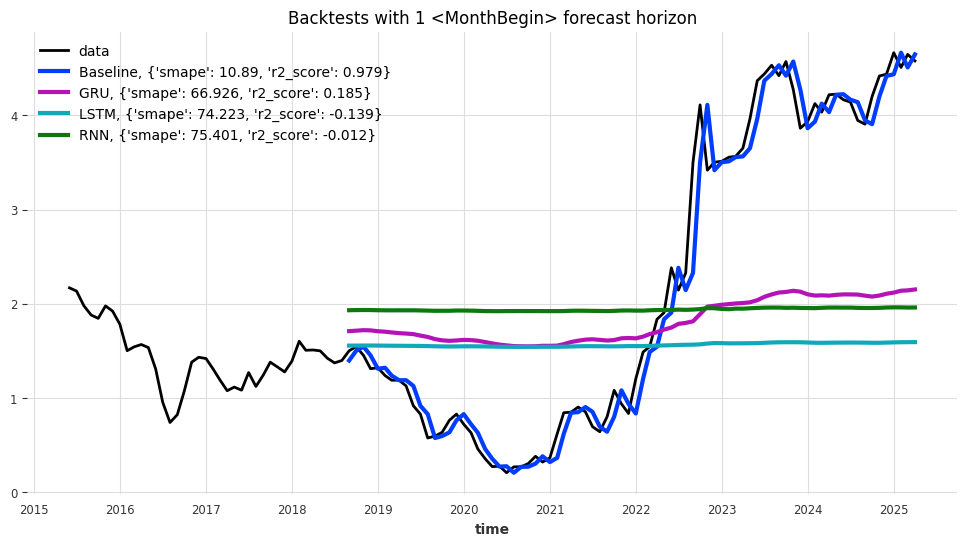

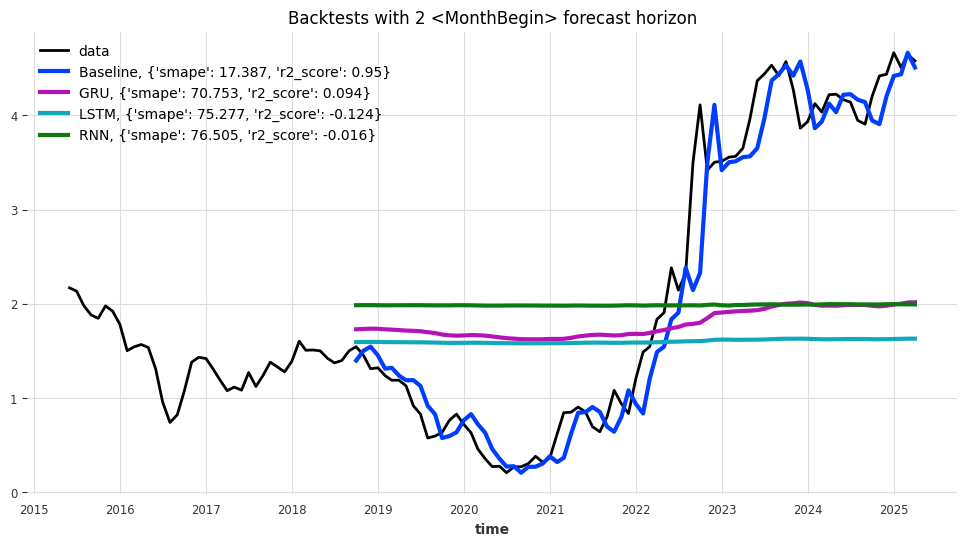

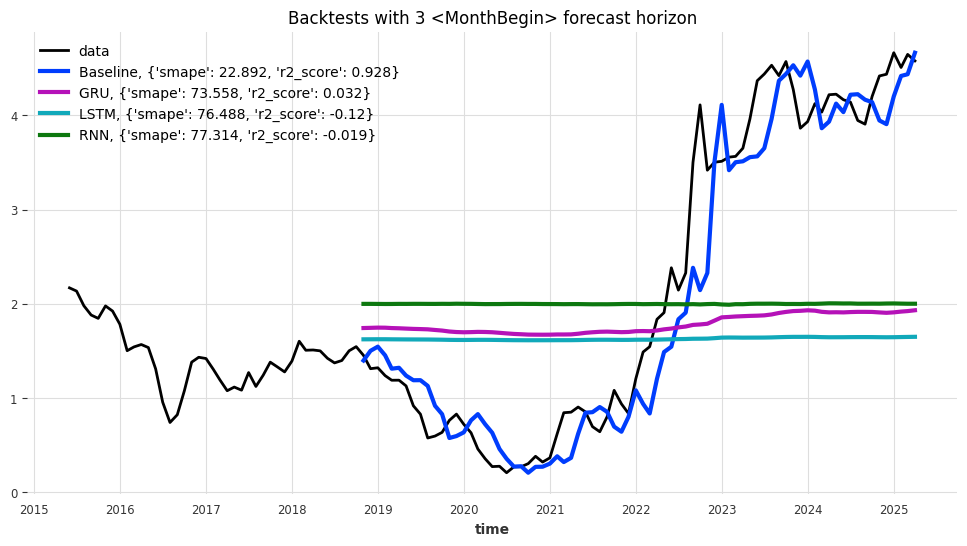

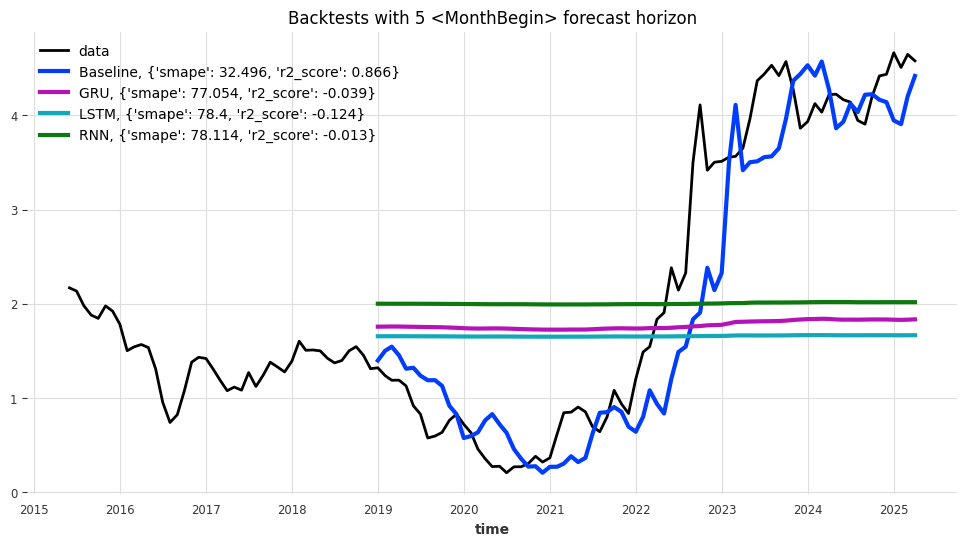

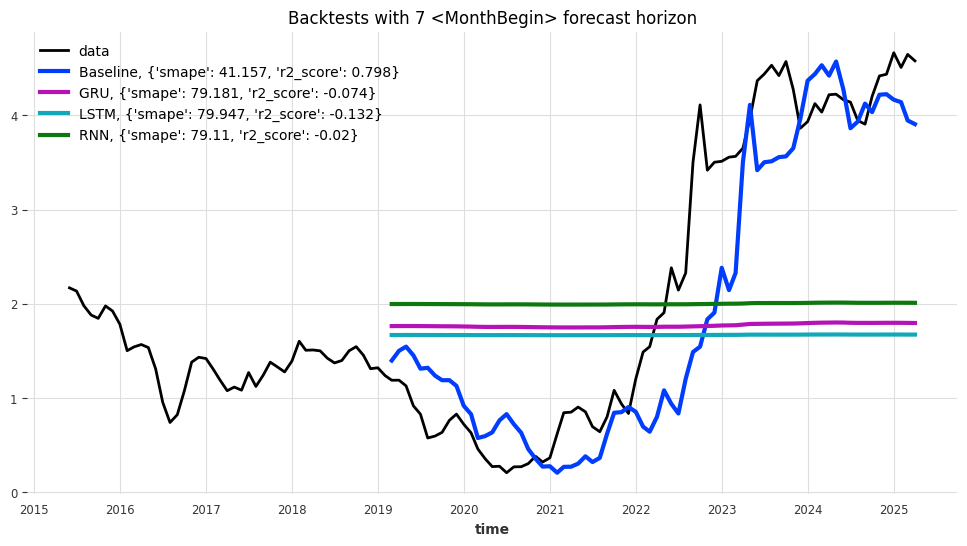

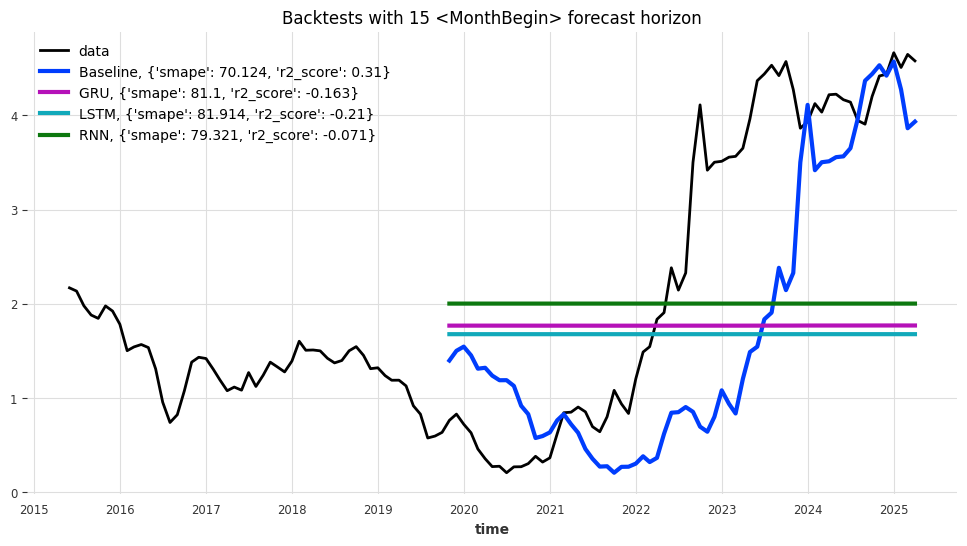

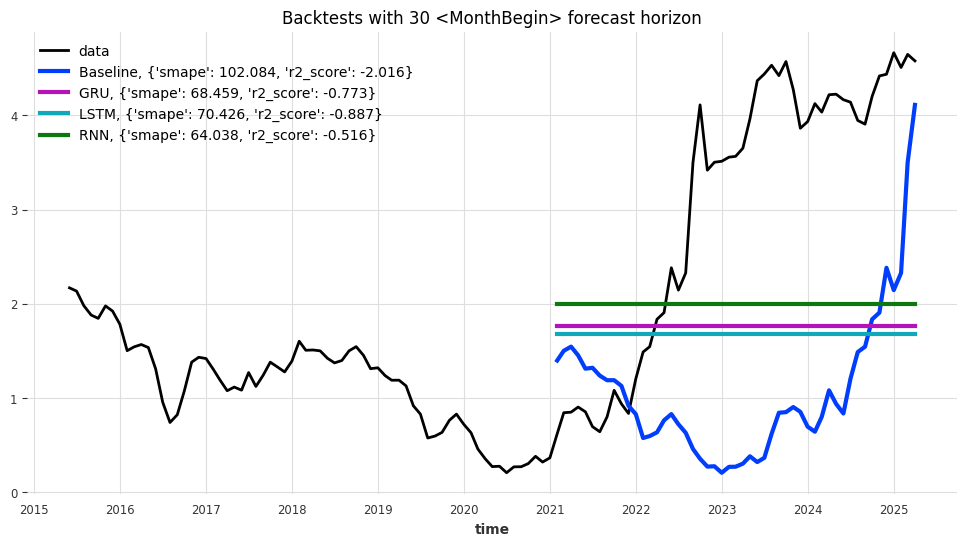

In [77]:
plot_backtest_results(
    series, 
    results, 
    points_to_test=len(test)
)


### Comparação da otimização dos modelos da família RNN

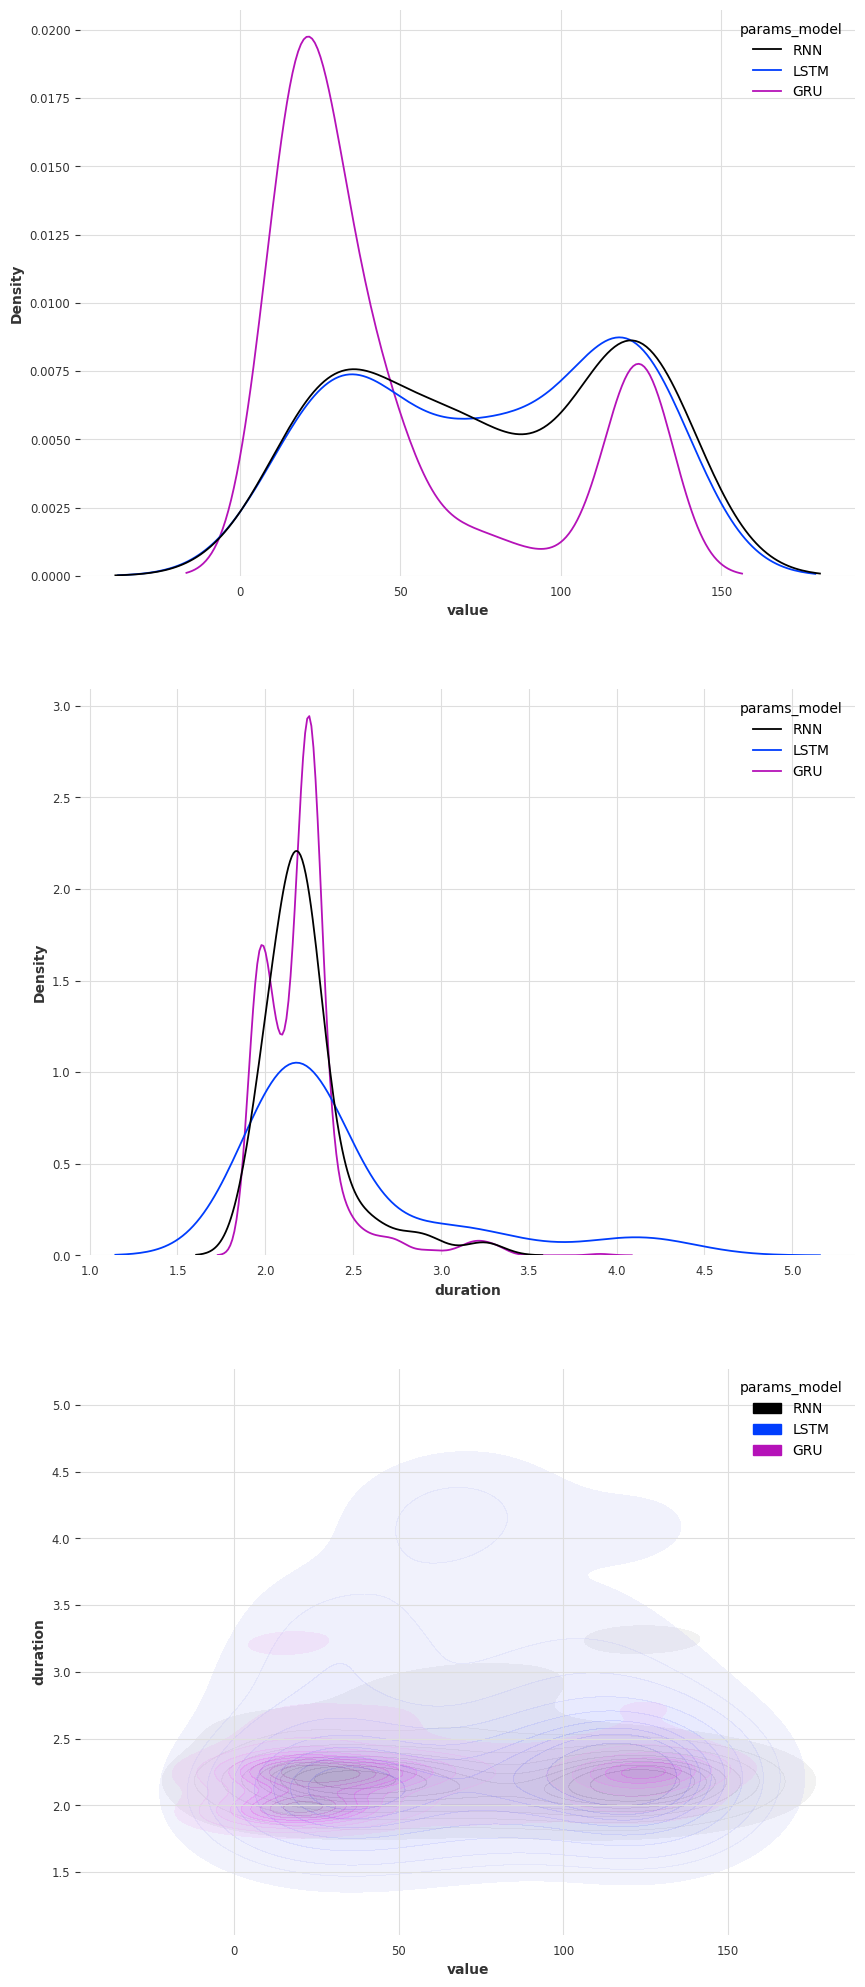

In [78]:
# sns.set(style='dark',)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))
sns.kdeplot(study_df, x="value", hue="params_model", ax=ax1, common_norm=False)
sns.kdeplot(study_df, x="duration", hue="params_model", ax=ax2, common_norm=False)
sns.kdeplot(study_df, x="value", y="duration", hue="params_model", ax=ax3, common_norm=False, fill=True, alpha=.2)

plt.show()